---

## Technical Report - Notebook 5

---

# Can Social Data Predict Natural Catastrophes?

_An investigation into whether twitter data can predict severe natural events that cause major economic loss._



![storm_image](images/brisbane_hail_27112.jpg)


##### Tom Croshaw

Blog @  https://tcroshaw.github.io/

---

### Executive Summary

A natural catastrophe is defined by the Insurance Council of Australia to be a "large natural or man-made disaster that causes a significant number of claims in a region." This investigation sets out to determine whether social media can predict a severe natural catastrophe, more specifically, whether twitter data ('tweets') indicate a hail event is occurring and whether it is severe. Twitter data for two significant hail events - Brisbane (27-11-14) and Sydney (25-04-15) - was captured for the 24 hour periods surrounding each event. A preliminary exploratory data analysis on the twitter user information identified significant anomalies in the data, including automated posting services and users with extreme numbers of friends/followers. Excluding outliers for the continuous twitter user variables and removing anomalous sources increased the confidence of our data prior to the main investigation; analysing tweet text and developing a classification algorithm.

Followiing the user data analysis, natural language processing (NLP) techniques were used to explore the text communicated by each user during the two time periods. Once the data was cleaned of urls, characters and stopwords, a frequency analysis of the vectorised dataset outlined the most common terms in the samples. Words relating to the hail events were dominant and time analysis revealed clear signatures of users tweeting during the known hailstorm hours. Spatial analysis also revealed a second hailstorm in San Antonio on 25-04-15. The most fortuitious discovery however was a second type of catastrophe, the Nepal Earthquake on 25-04-15. This validated our search criteria and frequency analysis, and allowed our scope to expand beyond the hail-only classification. Topic modelling with latent Dirichlet allocation strengthened our understanding of how terms cluster within our events and sentiment analysis indicated that for both hail and earthquake tweets, the relative negative polarity frequency was greater than all-tweets combined.

A random forest classification model was found to be the optimal model for the hail class target. A principle component analysis suggests that limiting components would be ineffective in reducing dimensionality, therefore all predictors (i.e.: words in the vectorised, normalised data) were used in modelling. Whilst Naive Bayes, Stochastic Gradient Descent and Decision Trees all provided high accuracy score, their f1 scores were less than the ensemble random forest classifier. The best f1 score was was driven by the high recall value of the hail-class (1) prediction. When the random forest classifier was optimised via gridsearching, the hyperparameters and fit with 100% of the data increased the recall value to 0.82; a very positive result that suggest tweets can identify hail events without the key 'hail' word present.

When using the optimised model to train/test for each event, the classification results were poor despite the high accuracy scores. This indicates that the tweets from each events used differing language to communicate the hail. A second classifiction analysis - that used each event as class in a hail-only subset of the data - confirms this further; the model produced moderately strong classification results and words commonly used to describe severe events (_chaos, slammed, worst_) were the features with highest importance. 

A final analysis introduced earthquake as a class with hail. This again produced a high accuracy score of over 0.95 and strong classification metrics, particularly for earthquake. Further investigation is needed to determine how strong the earthquake classification performs alone and a key insight from the moderate performance by hail in the final exercise is that indepenent classification models for each natural peril are optimal rather than a combined classification. This is one of the main suggestions for future work, along with further algorithm investigation, event training and geographic sampling.

---

### Contents

1. Introduction: Problem Statement and Project Goals			
2. Data Aquisition and Querying				
3. Data Parsing: Identifying outliers, defining variables, cleaning data
    - Data pipelines - importing/sorting/querying/munging		
4. Statistical Analysis: Data correlation and visualisation											
5. Hail Modelling: Algorithm development and implementation process				
    - Principle Component Analysis
    - Model Development, Tuning and Evaluation
6. Hail Severity Modelling
7. Earthquake Classification
8. Analysis Conclusions: Interpretation of Findings and Goal Review		
9. Stakeholder Recommendation and Next Steps
10. Model Deployment: Retraining and Production

In [3]:
from IPython.display import Image
from IPython.display import display

### 1. Introduction

The overall goal of this project is to assess whether Twitter data can predict a 'natural catastrophe'.

The Insurance Council of Australia (ICA) classifies a catastrophe as:"large natural or man-made disasters that cause a significant number of claims in a region." More specifically 'catastrophes' refer to events that have:
- Significant financial/insurance loss (> 10M AUD)
- Significant number of claims or damage reports
- Wide reported geographic extent

This project aims to not predict whether a natural event will occur, but whether tweets indicate a catastrophic event is occurring and if so, will be severe or highly damaging?

As it was not possible to analyse all catastrophe types within the timeframe of the investigation, I will focus on analysing Twitter data for two major Australian hail storm events:
 1. Brisbane Hail Storm (27th November 2014): AUD 1,400m insurance loss
 2. Sydney Hail Storm (25th April 2015): AUD 400m insurance loss

These events were chosen because they are two of the most significant hail storms (from an insurance perspective) during the Twitter age, but their catastrophic loss attributes (loss, claims and geography) are quite different.

Refining the problem statement... the two specific goals of this project can be represented in two key questions:

    - Can twitter data detect hail events from the language people use in tweets?
    - Can twitter data identify catastrophic hail events of differing severity?

Identifying language in tweets that confirms a specific **type of event** is occuring (i.e.: hail),  whether the language indicates a **severe event** and analysing sentiment are critical components of this analysis. These will help determine whether a model can effectively classify twitter data as part of a major event.

This report will outline the methods and results of the investigation. I will finish with a review of the successes and how this model could be deployed in real time.

### 2. Data Acquisition & Querying

I sourced my main datasets from Sifter. Sifter is a service that provides search and retrieve access to every undeleted Tweet in the history of Twitter.

https://sifter.texifter.com/

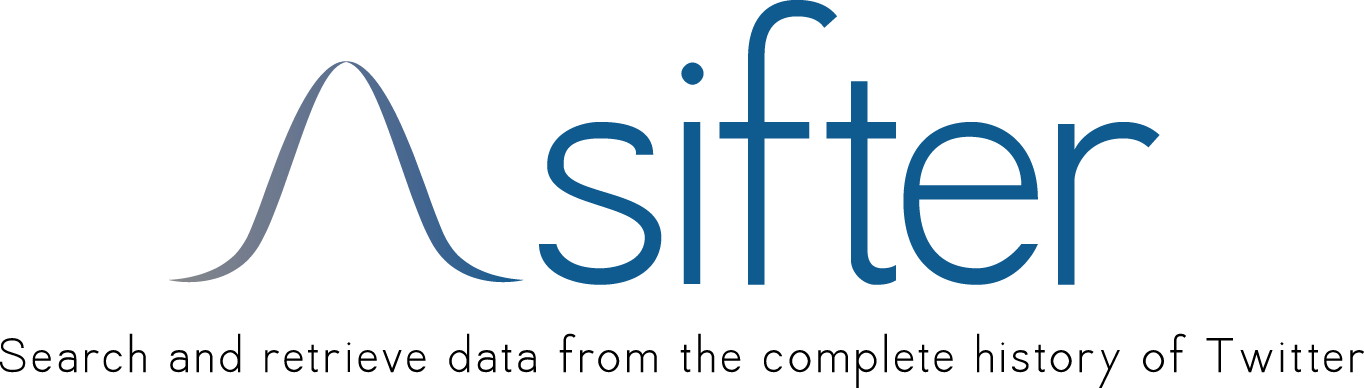

In [4]:
Image(filename='./images/sifter.png',width=200)


For my project I purchased two datasets:

- Primary dataset: Brisbane Hail storm on 27th November 2015 With the help of sifter, I performed the following search function to extract the data:

_Rule: (contains hail OR storm OR damage OR flood OR insur OR "golf ball"~6 OR "tennis ball"~6 OR lightning OR thunder OR #brisbanehail OR #brisbanestorm OR "brisbane hail"~6 OR "brisbane storm"~6 OR #australiahail OR #australiastorm OR "australia hail"~6 OR "australia storm"~6 OR #auhail OR #austorm OR "au hail"~6 OR "au storm"~6 OR #qldhail OR #qldstorm OR "qld hail"~6 OR "qld storm"~6 OR #queenslandhail OR #queenslandstorm OR "queensland hail"~6 OR "queensland storm"~6 -(brisbane OR qld OR queensland OR australia OR au OR seqld) All duplicates removed._

This query aimed to capture all potential tweets that could relate to the identified hail event on 27th November 2014. I extracted 3 days worth of data however I will only analyse a 24 hour period surrounding the known time of the hail storm (15:00 - 17:00 AEDT), as I am primarily interested in the 'real-time' twitter indicators. This event was more widespread and had a higher insured loss, I will use this as my primary dataset for the EDA/model building (i.e.: my training data). The final dataset was delivered in csv format.

- Secondary dataset: Sydney Hail storm I performed a similar search in Sifter to gather data for a hail event in Sydney on 25th April 2015.

_Rule: (contains hail OR storm OR damage OR flood OR "golf ball"~6 OR "tennis ball"~6 OR insur OR lightning OR thunder OR #sydneyhail OR #sydneystorm OR "sydney hail"~6 OR "sydney storm"~6 OR #australiahail OR #australiastorm OR "australia hail"~6 OR " australia storm"~6 OR #auhail OR #austorm OR "au hail"~6 OR "au storm"~6 OR #nswhail OR #nswstorm OR "nsw hail"~6 OR "nsw storm"~6 -(sydney OR nsw OR "new south wales" OR australia OR au) All duplicates removed._

This dataset was used as my secondary data . The final dataset was delivered in csv format.

Supporting dataset: ICA Catastrophe Data 2016 This dataset was sourced from the Insurance Council of Australia (ICA). The Insurance Council of Australia collects catastrophe related claims data from the Australian market as part of its role in supporting the industry to deliver repairs, rebuilding and recovery services following large disasters. The ICA Catastrophe Database commenced in 1967 and records insurance loss estimates for declared insurance catastrophe events.

This dataset was used to extract the insured loss for the Brisbane and Sydney hail events and will be used as a reference through the project. It will also serve as a useful guide for future events to investigate.

---

### 3. Data Parsing: Identifying outliers, defining variables, cleaning data, feature engineering

This section of the report outlines how data was prepared for modelling. I found that analysing text data can be challenging, particularly Twitter data(!), but if NLP is performed correctly the results can be powerful.

The preparation of data can be broken down into two main processes, or **pipelines**:

A. Twitter User Data Preparation: Using the atrributes associated with each tweet to remove irrelevant columns, anomalous records and data outliers. This refines the tweet records to increase the confidence of the data.

B. Tweet Text Data Preparation: Using NLP processes to clean the text data and create a vectorised dataset of key words. This data is what we will use in modelling.

**A. Twitter User Data Preparation / Engineering:**

The priority of this exercise was to clean the dataset to ensure the remaining tweets are of good quality. I will discuss the preparation process in a pipeline:
    1. Clean column names to remove unnecessary characters
    2. Drop completely *null* and columns not needed
    3. Remove outliers from continuous features: in the user data there are 5 of these variables overall and outliers were removed according to an appropriate standard deviation.
    4. Time variables are engineered to create hour, minute, second features.
    5. Investigate devices and remove any anomalous sources from the final dataset
    6. Reset index for final dataframe
    7. Export final dataframe to CSV for storage.



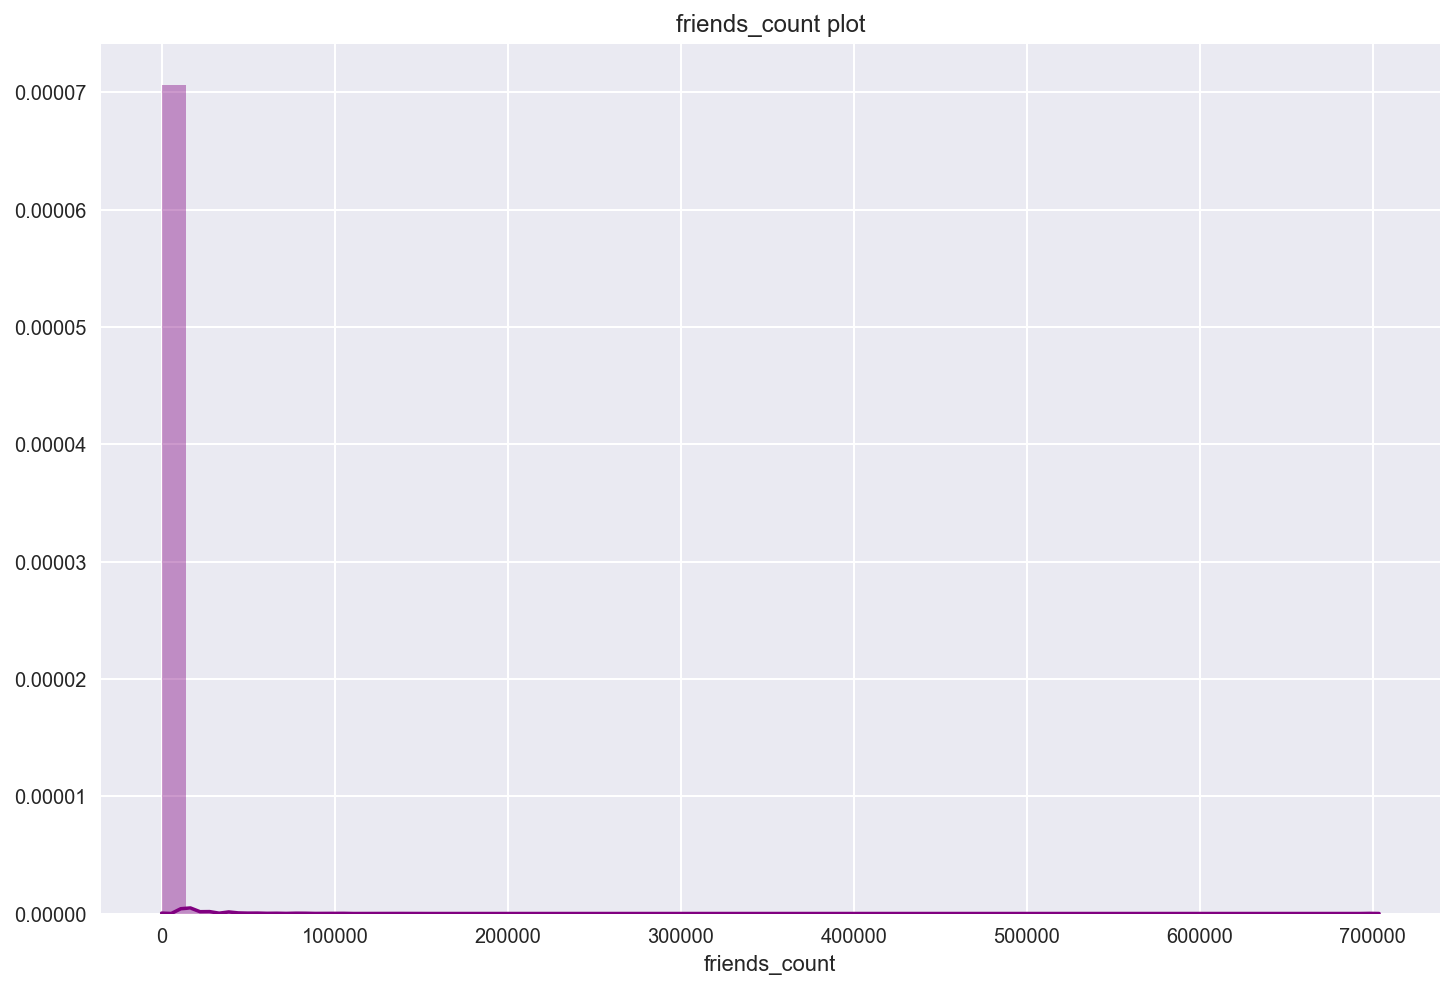

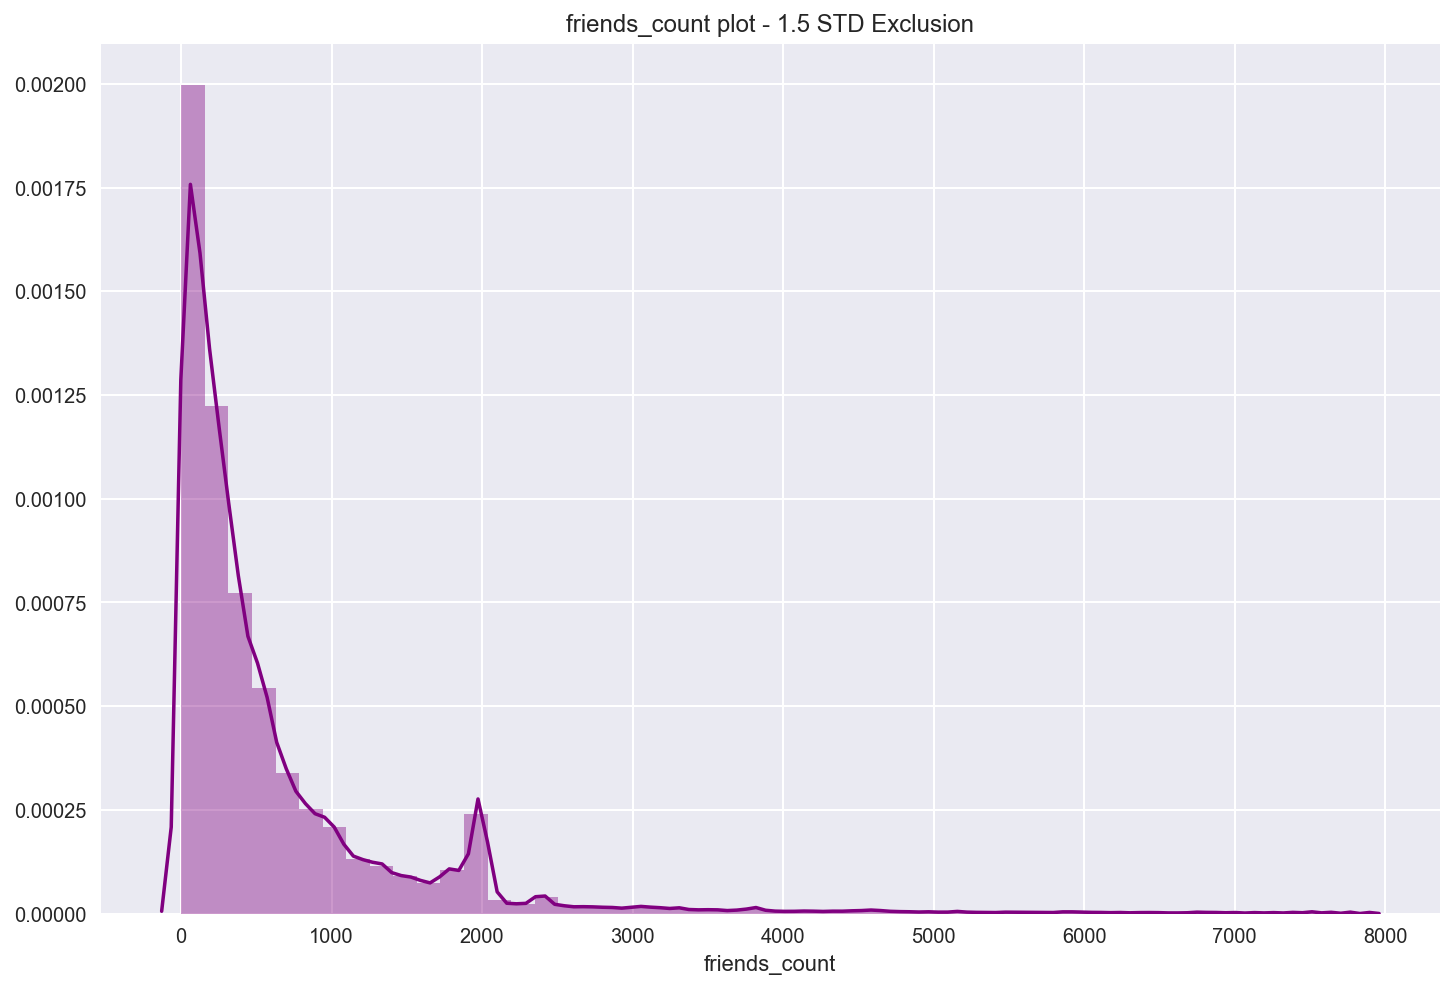

In [5]:
# Figure 1. Removing outliers for the friends_count user variable
x = Image(filename='./images/friends_count1.png',width=700)
y = Image(filename='./images/friends_count2.png',width=700)
display(x,y)

Cleaning the user information is an important step to improve the confidence of my records. Identifying irrelevant data sources (e.g.: Twittascope) and cleaning the data was a very important step. Feature engineering of the date information allows plotting over time, and removing outliers (of all numeric user variables) ensures records that are potentially misleading from media or 'bots' with unusually high numbers of friends, influence scores etc.

_Insights from the user data analysis will be discussed in the 'Statistical Analysis' section._

**B. Twitter User Data Preparation / Engineering:**

The second stage of data processing prepares the actual tweet text for each record - this is the core dataset that I will use in modelling. The priority of this exercise was to create a dataset of key tweet words that can be used to create predictor and target variables. I will again discuss the tweet preparation process as a pipeline:
    1. Call stop words, adding further words as appropriate (i.e.: words identified later in the Bag of Words and Topic Modelling analysis).
    2. Parse each tweet text record with the 'clean_tweet' function. This removes links, symbols and numbers, converts words to lowercase and appends the final text to a new list
    3. Count vectorisation: A 1000 word limit was applied when vectorising the tweet text as only the terms of greatest influence are of interest (and many of the words captured within this limit have a 1 frequency in any case).
    4. Remove any further anomalous records ('gemini' another term that was revealed to indicate automated postings from horoscope sites)
    5. Concatenate dataframe with original user data.
    6. Bag-Of-Words Analysis: Investigating word frequencies for data subsets (e.g.: time periods), correlations and geographic distribution
    7. Topic Modelling: Application of latent Dirichlet allocation model to investigate word clusters
    8. Sentiment Analysis: using Textblob to review simple sentiment scores
    
The above natural language processes were very important in my analysis. The sequence in which they are performed is critical, particularly when working with twitter data because urls and emojis introduce anomalous characters between words and spelling mistakes are common. Different orders were applied and final 'clean_tweet' function was found to be optimal.

Lemmatisation was investigated but this removed detail from the words, so was not used. Also, because a later stage was sentiment analysis lemmatisation could potentially reduce the impact of this process. 

Bi-grams and tri-grams were also researched however were not used in the final modelling as they caused too much repetition of certain terms at high frequencies, which would impact detail in the model.

Bag-Of-Words, Topic Modelling and Sentiment Analysis will now be discussed in the 'Statsitical Analysis' section of the report.

---

### 4. Statsitcal Analysis: Relationships, Visualisations and NLP Results

Following the two data cleaning processes, data exploration and statistical analysis was performed. This revealed valuable insights and allowed further cleaning and feature engineering. The results of the user data and tweet text analyses will now be discussed.

#### User Data Analysis:

The primary purpose of the statistical analysis on the user variables was to reduce the dataset to increase the confidence of the users. This was primarily done by removing nulls, anomalous sources and outliers appropriate to the variables. Some key insights from the correlation and visualisations include:
- The mean number of statuses is high. People in our sample obviously tweet a lot...
- Statuses, Followers and Friends count distribution are less positively skewed with the oulier removal.
- Despite the low penalty (1 STD) for the influence score, some very high values are still recorded. Because of this, replacing nulls with the median influence score instead of the mean was deemed more appropriate.
- There is little correlation beween the 5 variables, the most being between the influence score and followers. As we are unsure how the influence score is determined, we can conclude it is unlikely to be directly proportional to any of the other numeric variables.

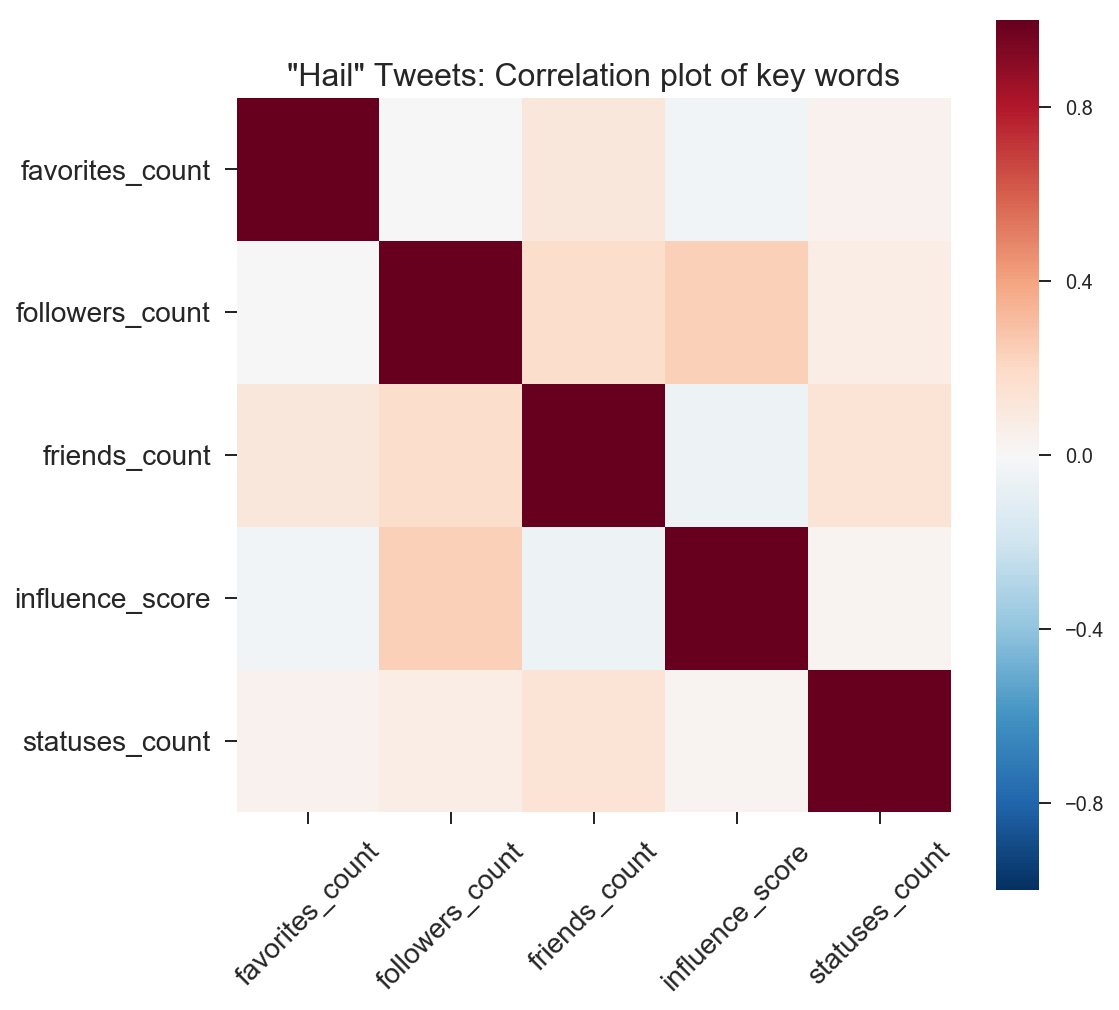

In [6]:
# Figure 2: User data correlation plot
Image(filename='./images/user_variables_corr.png',width=500)

Device types were also investigated. Early on in the analysis a source called 'Twittascope' was found that has ~27,000 tweets associated with it from 27th November. 

**"About Twittascope.com:** _Twittascope tweets authentic horoscopes for your Twitter account each morning. Provided by the Daily Insight Group, this leading horoscope service offers a daily dose of astrological insight."_

These records did not have reliable tweets from actual people (an automated tweeting service), certainly not concerning our natural catastrophe events, so whilst the sample size is large, these tweets were excluded from the final dataset. All other sources were kept.

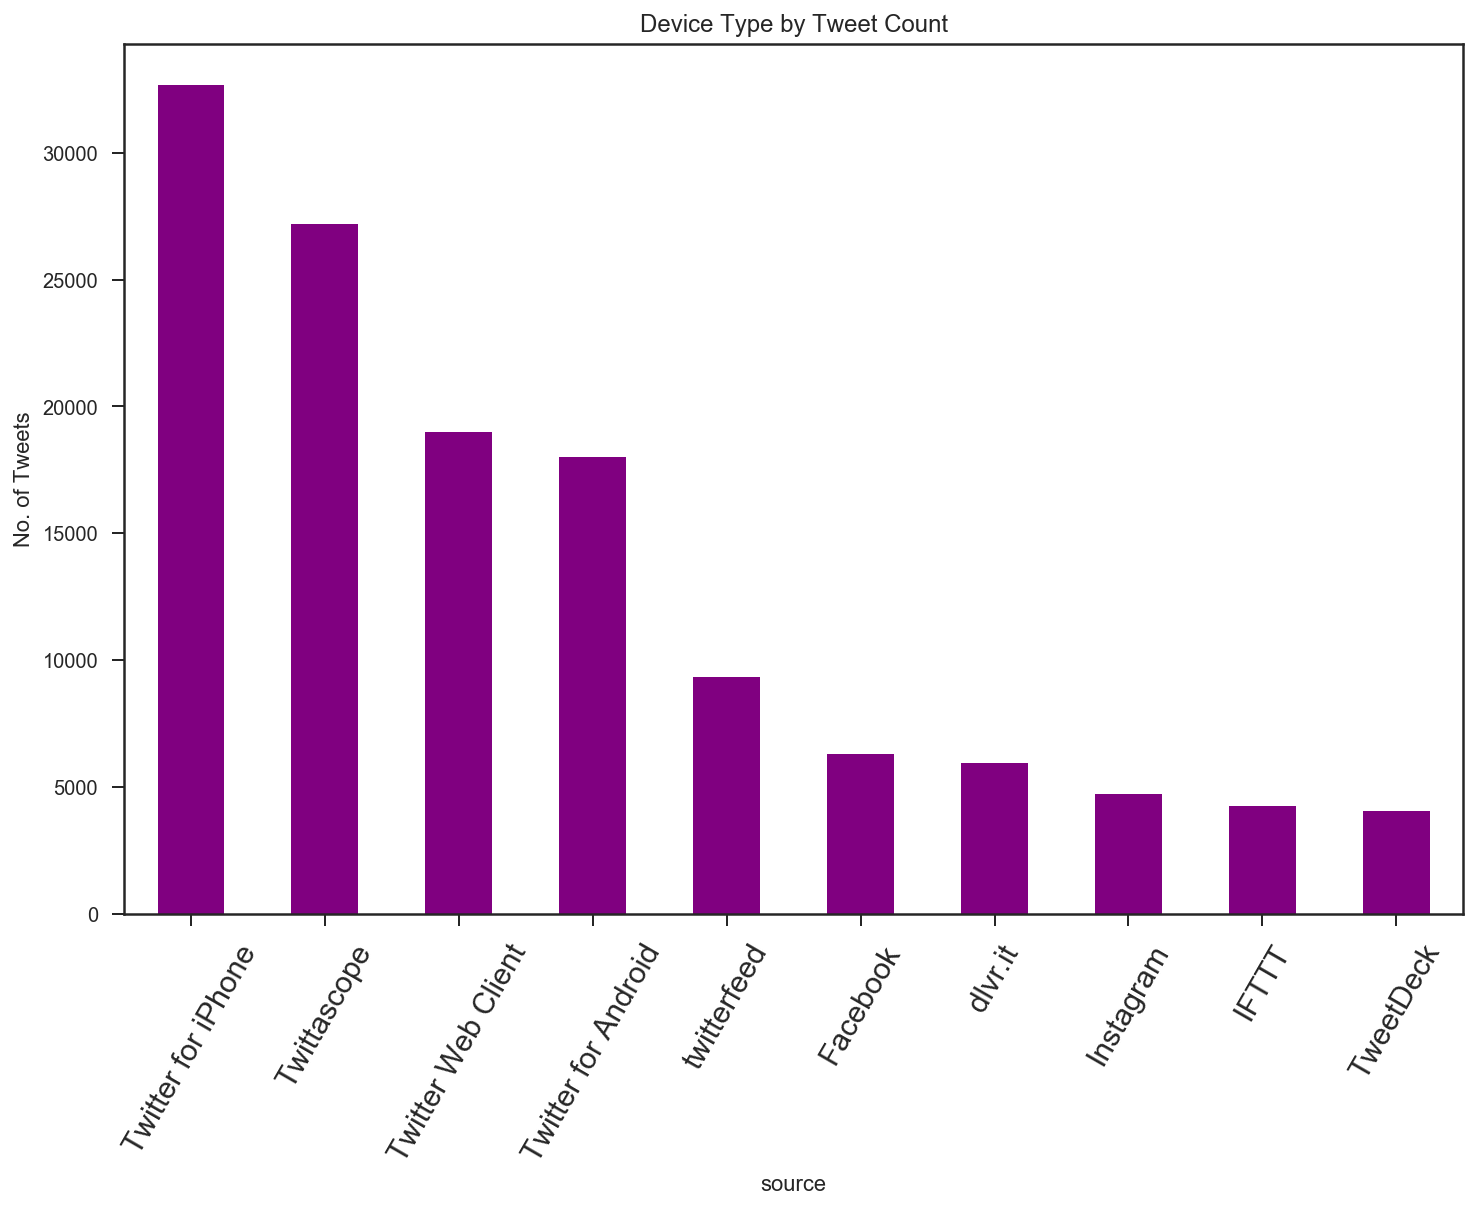

In [7]:
# Figure 3: Twitter data sources
Image(filename='./images/twitter_sources.png',width=800)

Although the user information will not be used in the modelling (as it is primarily an investigation into how twitter langauge can predict hail events) it was important to perform to significantly improve the confidence of our dataset. 

#### Tweet Data Observations: 

_A three part statistical analysis..._

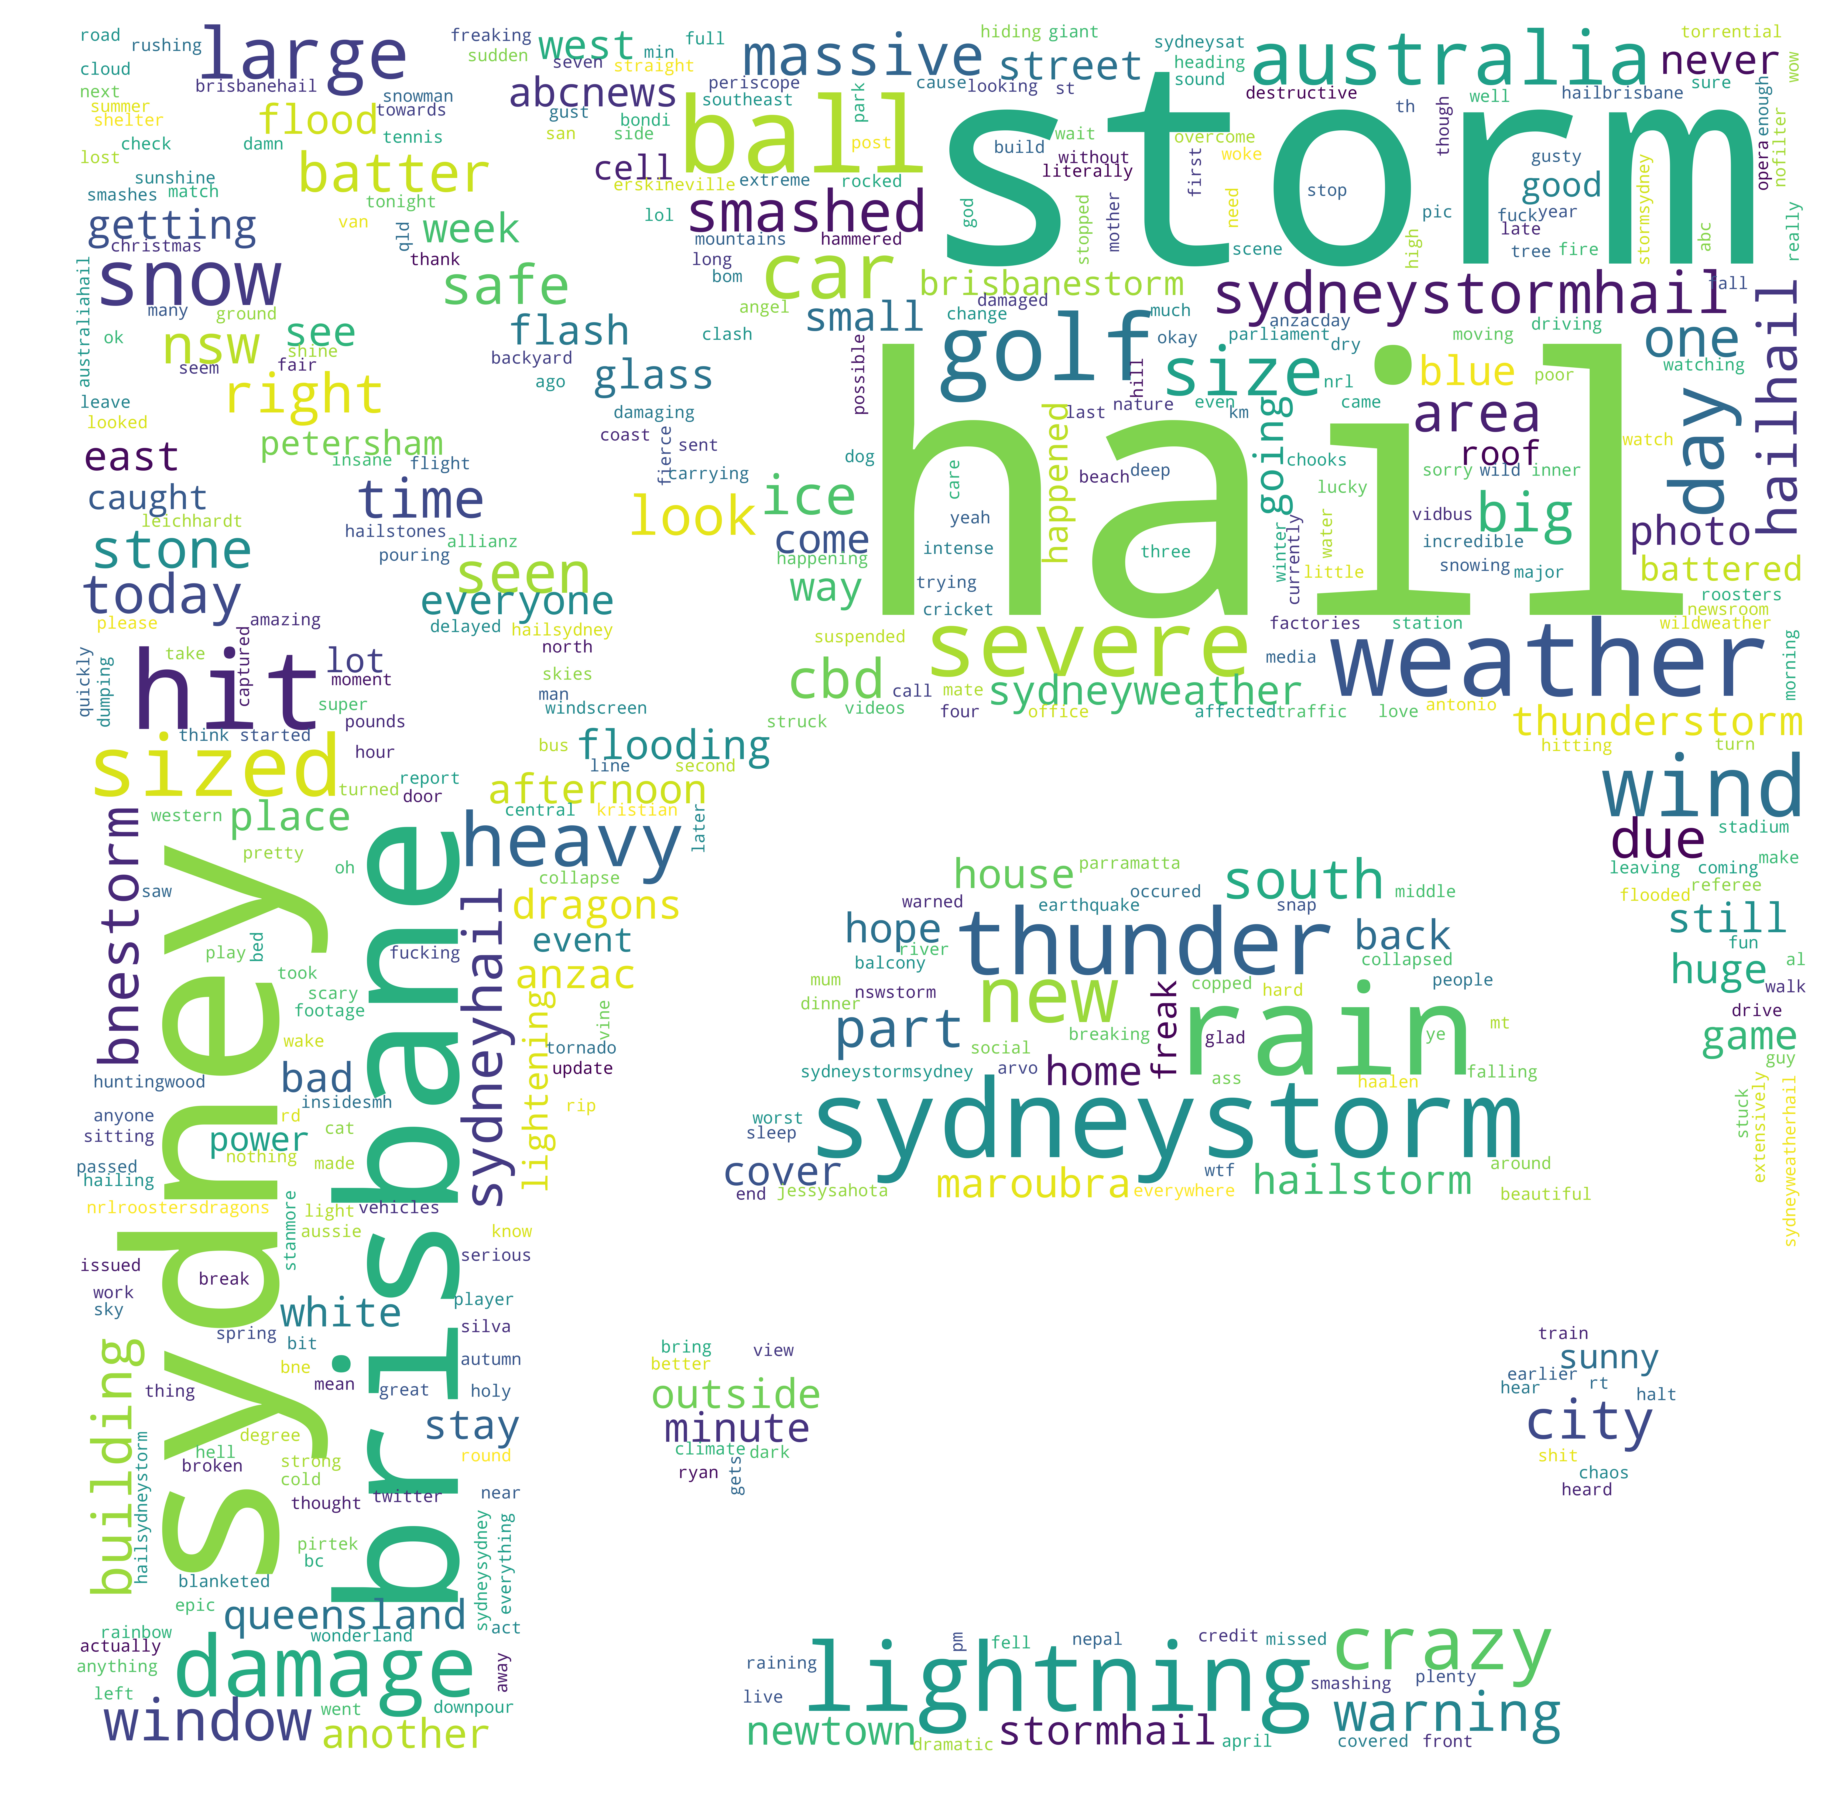

In [8]:
# Figure 4: Wordcloud of terms associated with 'hail' tweets 
Image(filename='./images/hail_cloud.png',width=900)

_Bag-Of-Words Analysis:_

This analysis reviewed the frequency of words, identifying key terms within the tweet text for the whole dataset and for our two independent events. It also indentified additional data to exclude (i.e.: the term 'gemini') and we observed the most common words used with our key word 'hail'. It also helped identify other key events, which indicates the strength of the natural language processing techniques employed.

The statistical analysis of this data has shown that within our sample, there is clearly a skew of word counts to a low frequency, however there are some key words which are prevalent throughout the tweets with similar high counts due to the volume of tweets on that subject (i.e.: the hail events). Comparing words that occur during the two events, especially over time, has been crucial in supporting my idea that twitter can identify natural catastrophes. So much so a second type of catastrophe was discovered!

Out of all NLP analysis techniques this has certainly been the most revealing and I will now outline some of the major insights:

- Correlation plotting of the most frequent words discovered a major earthquake event - the Nepal Earthquake on 25th April 2015. This was a significant disaster that caused economic loss of close to 50% of Nepal's GDP. This serendipitous discovery was a major success of my project, as it not only proved the analysis criteria can extend beyond than the original goal (to predict hail) to capture other types of events, but it also meant the scope could be broadened by adding a third modelling investigation. The highest correlated words in the full dataset are earthquake related: **quake, hits, big and Nepal...** which outlines how common these terms are used together in tweets during this type of event.

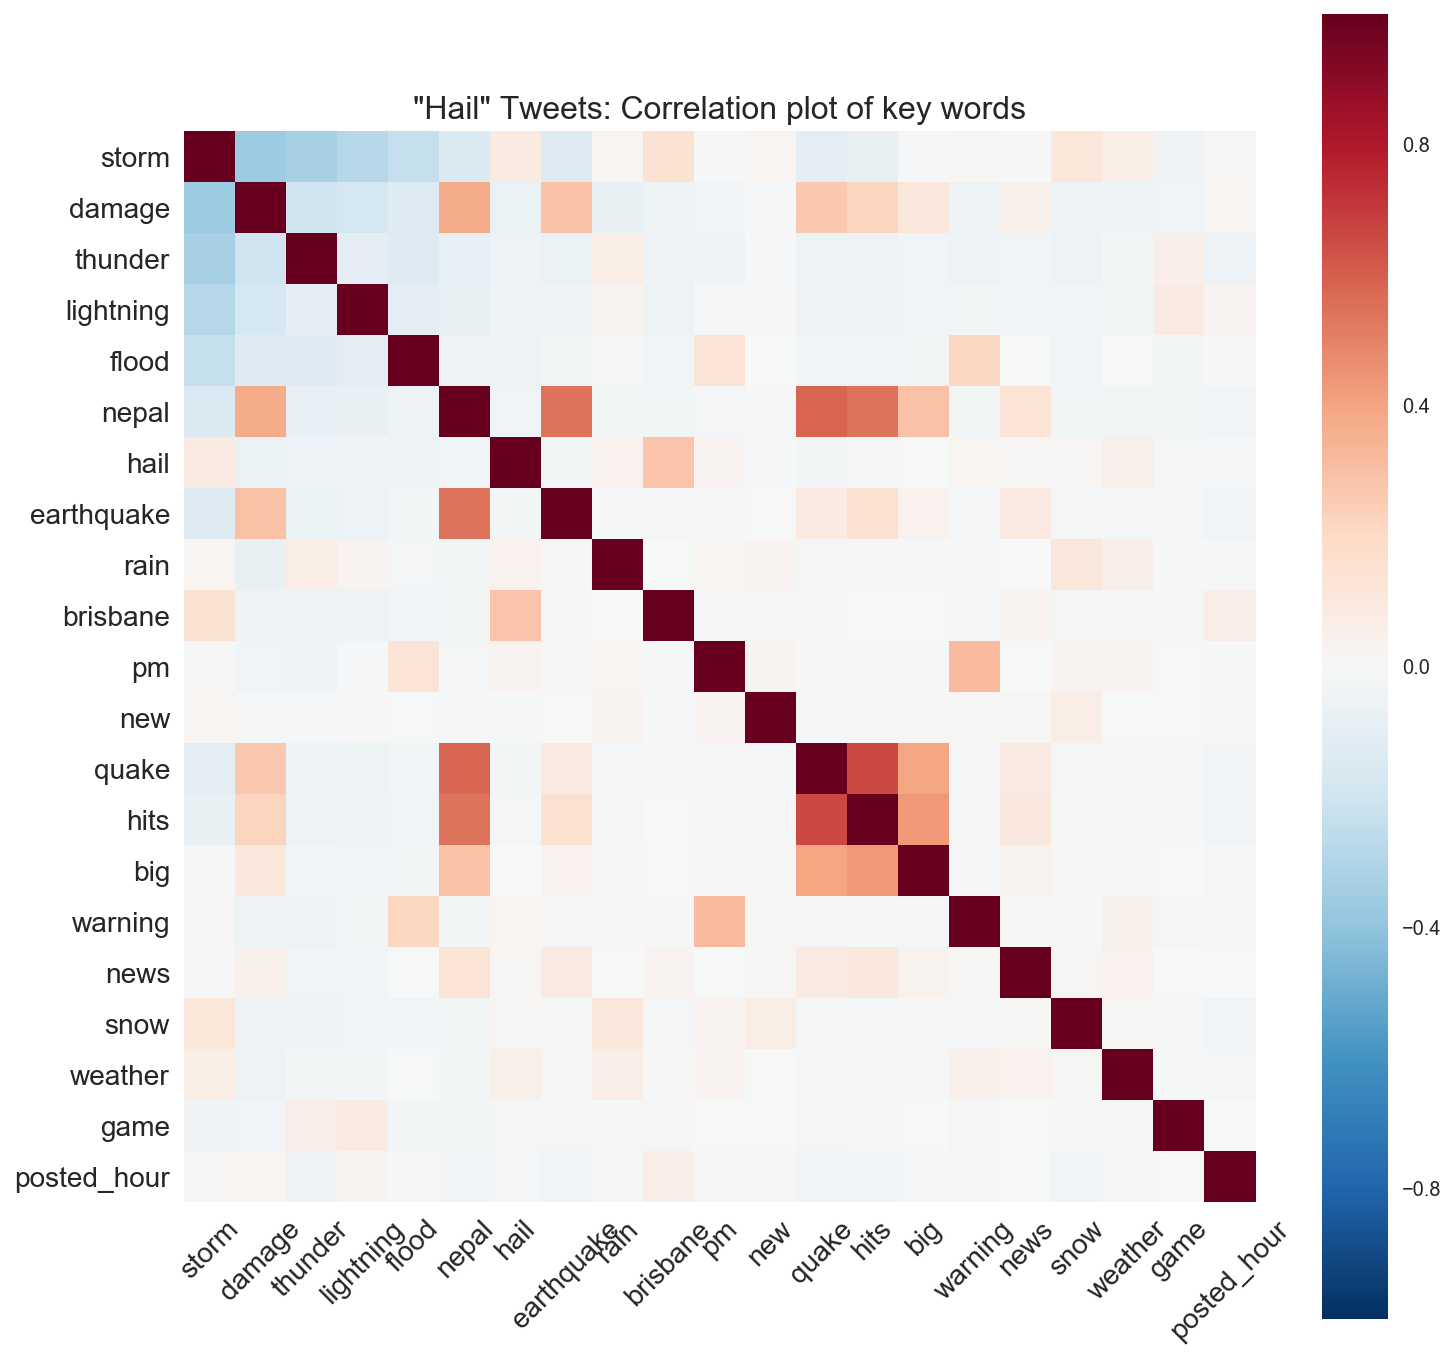

In [9]:
# Figure 5: Correlation plot of the top-20 most frequent words
Image(filename='./images/bow_all_corr.png',width=800)

- Time/word frequency plots of the two events (Brisbane Cat_ID 144, Sydney Cat_ID 154) show two interesting observations. The first is that both events occur at the same time of day (3-5pm AEST), which is consistent with what we know about the timing of both events, and more commonly confirms the expectation that hail storms occur later in the day during summer months. Secondly, there is a spike in the Brisbane storm nearly 10 hours later. It is unclear what caused this spike... possibly international reporting when the severity was realised?

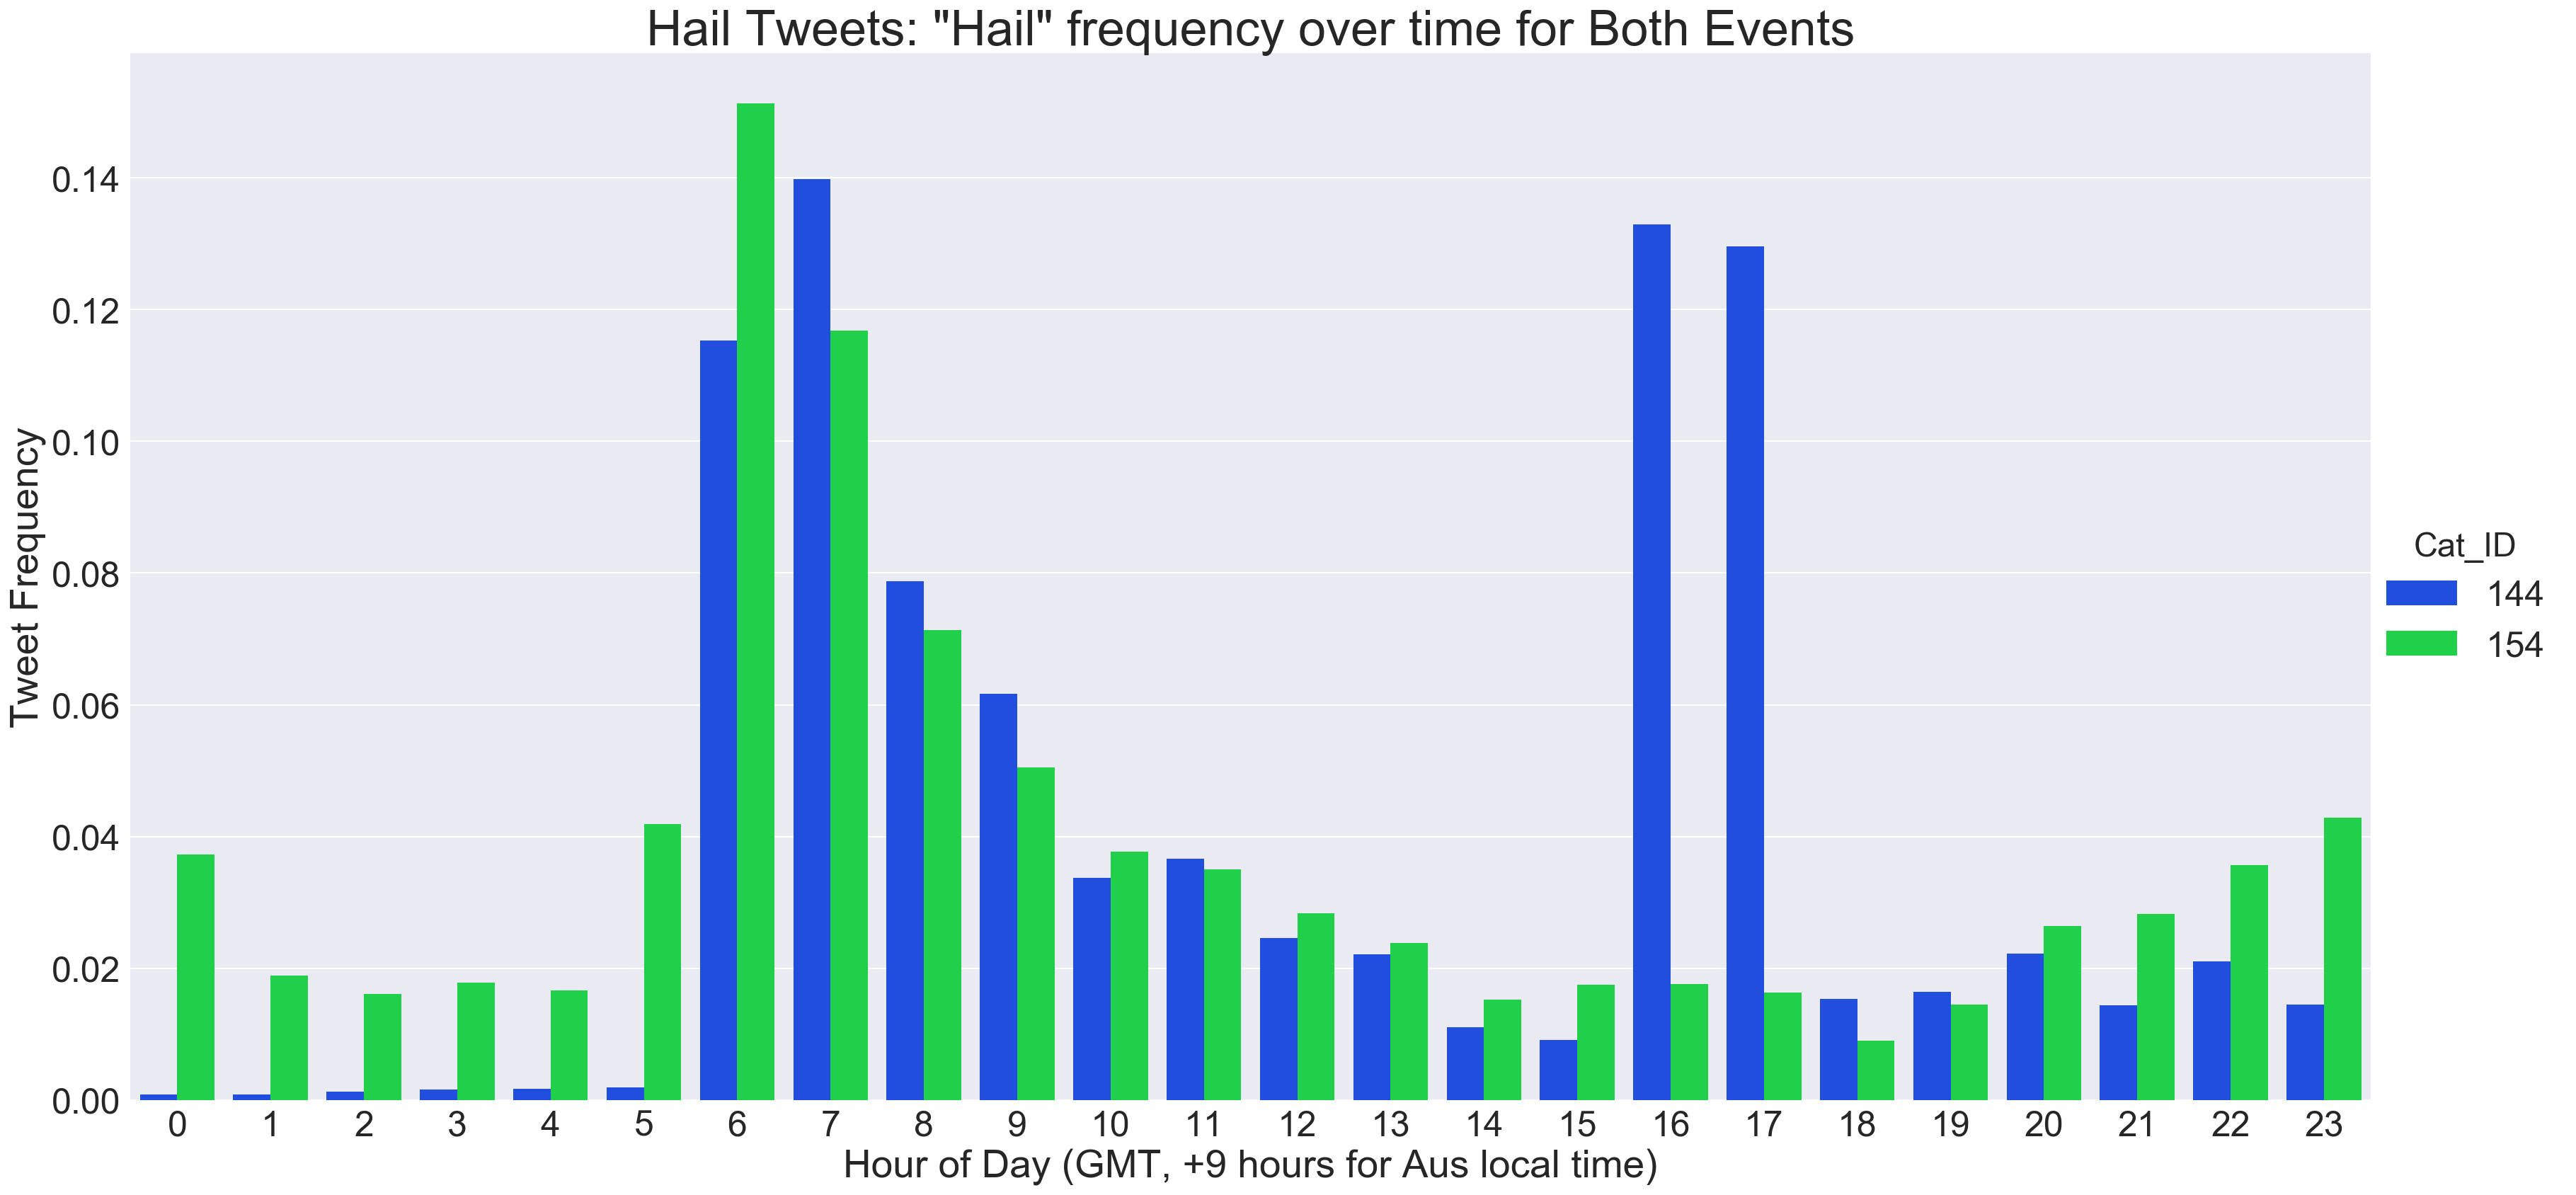

In [10]:
# Figure 5: Twitter data sources
Image(filename='./images/hail_time.png',width=1000)

- A geographic analysis of the tweet data found a concentration in 'hail' tweets over Texas. Investigation found there was another hail event that occurred on 25th April 2015 in San Antonio, causing hail storms of up to 2 inches. There is little evidence to suggest this was very damaging but could explain the gradual rise in hail tweets in the latter hours of Cat_ID 154.

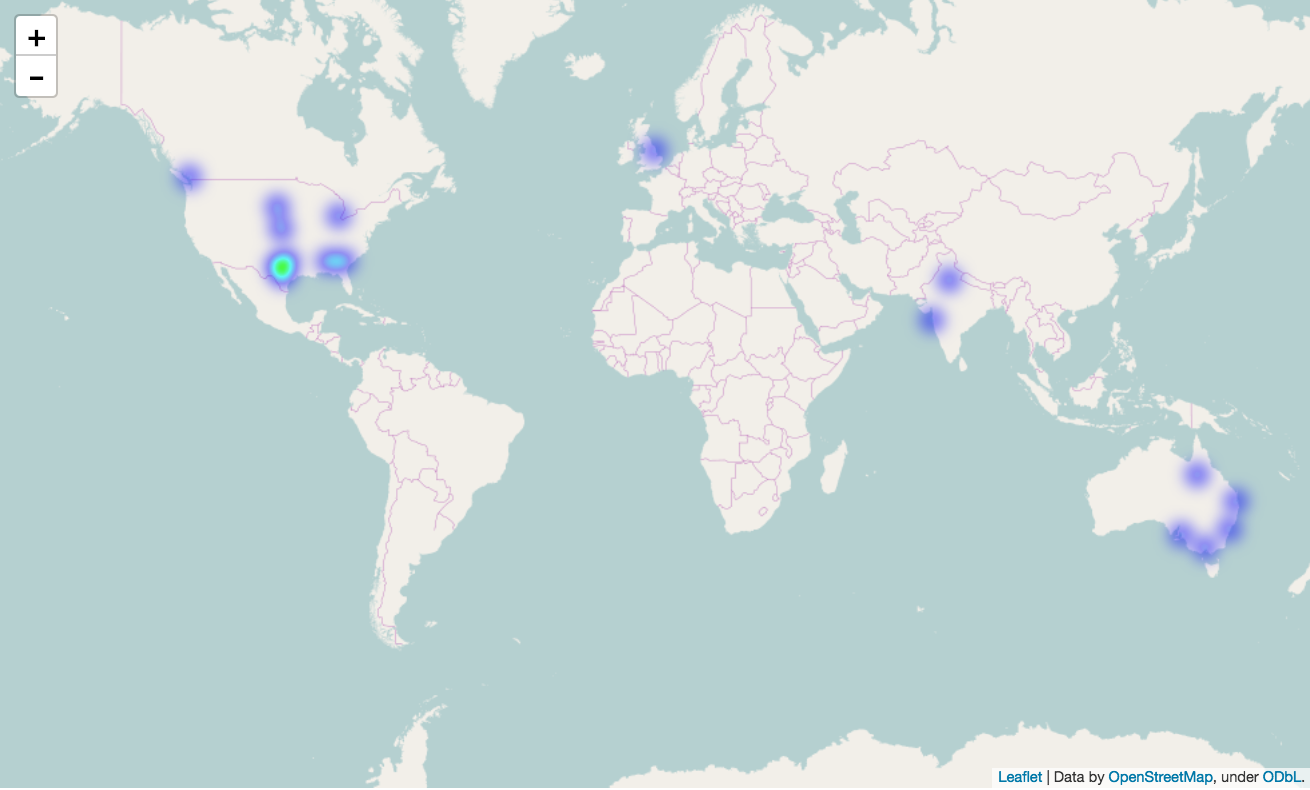

In [11]:
# Figure 6: Heat Map of hail only tweets
Image(filename='./images/map_hail_tweets.png',width=1000)

- Finally, when plotting the most frequenct words used with "hail", 'storm' is the most prevalent during both events but the two interesting terms used more in the Brisbane event (Cat_ID 144) are 'golf' and 'ball'. These words are key indicators of damaging hail as many people relate hail size to objects such as golf or tennis balls. We know already that the Brisbane event was much costlier from an insurance loss perspective and the prevalence of this term in this event is an **excellent indicator of severity**.

---
_Topic Modelling:_

Latent Dirichlet allocation, a algorithm used to identify topic clustering, found key groups of terms in the data, particularly for the hail events. This strengthens our understanding of the words used by twitter users during a hail event and helps identify other topics which may cause certain terms to deviate away from our expected classifications.

For the initial topic modelling I selected three grouping with 10 words. The three core topics identified in the data were:

- Group 0: **Storm** - A general clustering of terms related to storms: lightning, thunder, time, day, today, etc.
- Group 1: **The Nepal Earthquake** - As observed in the words EDA, the Nepal Earthquake is another major catastrophe that has been identified in the 25th April data. Here we observe _injuries, magnitude, causing, hits_ and other key words, however some other meterological terms slip in too.
- Group 2: **The [Sydney] hail event** - location information, damage, storm and it's characteristics clearly identify this group.

These topics classify the data well and if smaller groups of words were used, the topics would likely be more definitive.

This process also identified other major events in the data: thanksgiving, an NRL match and of course the Nepal Earthquake.  

The ability to relate words to known events is a valuable exercise and could certainly help when developing a model to categorise words in tweets.

- - -

_Sentiment Analysis:_

During severe natural catastrophes, people generally tweet emotive language to describe the events they're experiencing.

Textblob is a library for processing textual data. The *sentiment* function returns the polarity score - a measure of the negativity, the neutralness, or the positivity of the text. This function was parsed over all tweets to understand how sentiment varied for tweets referring to different events.

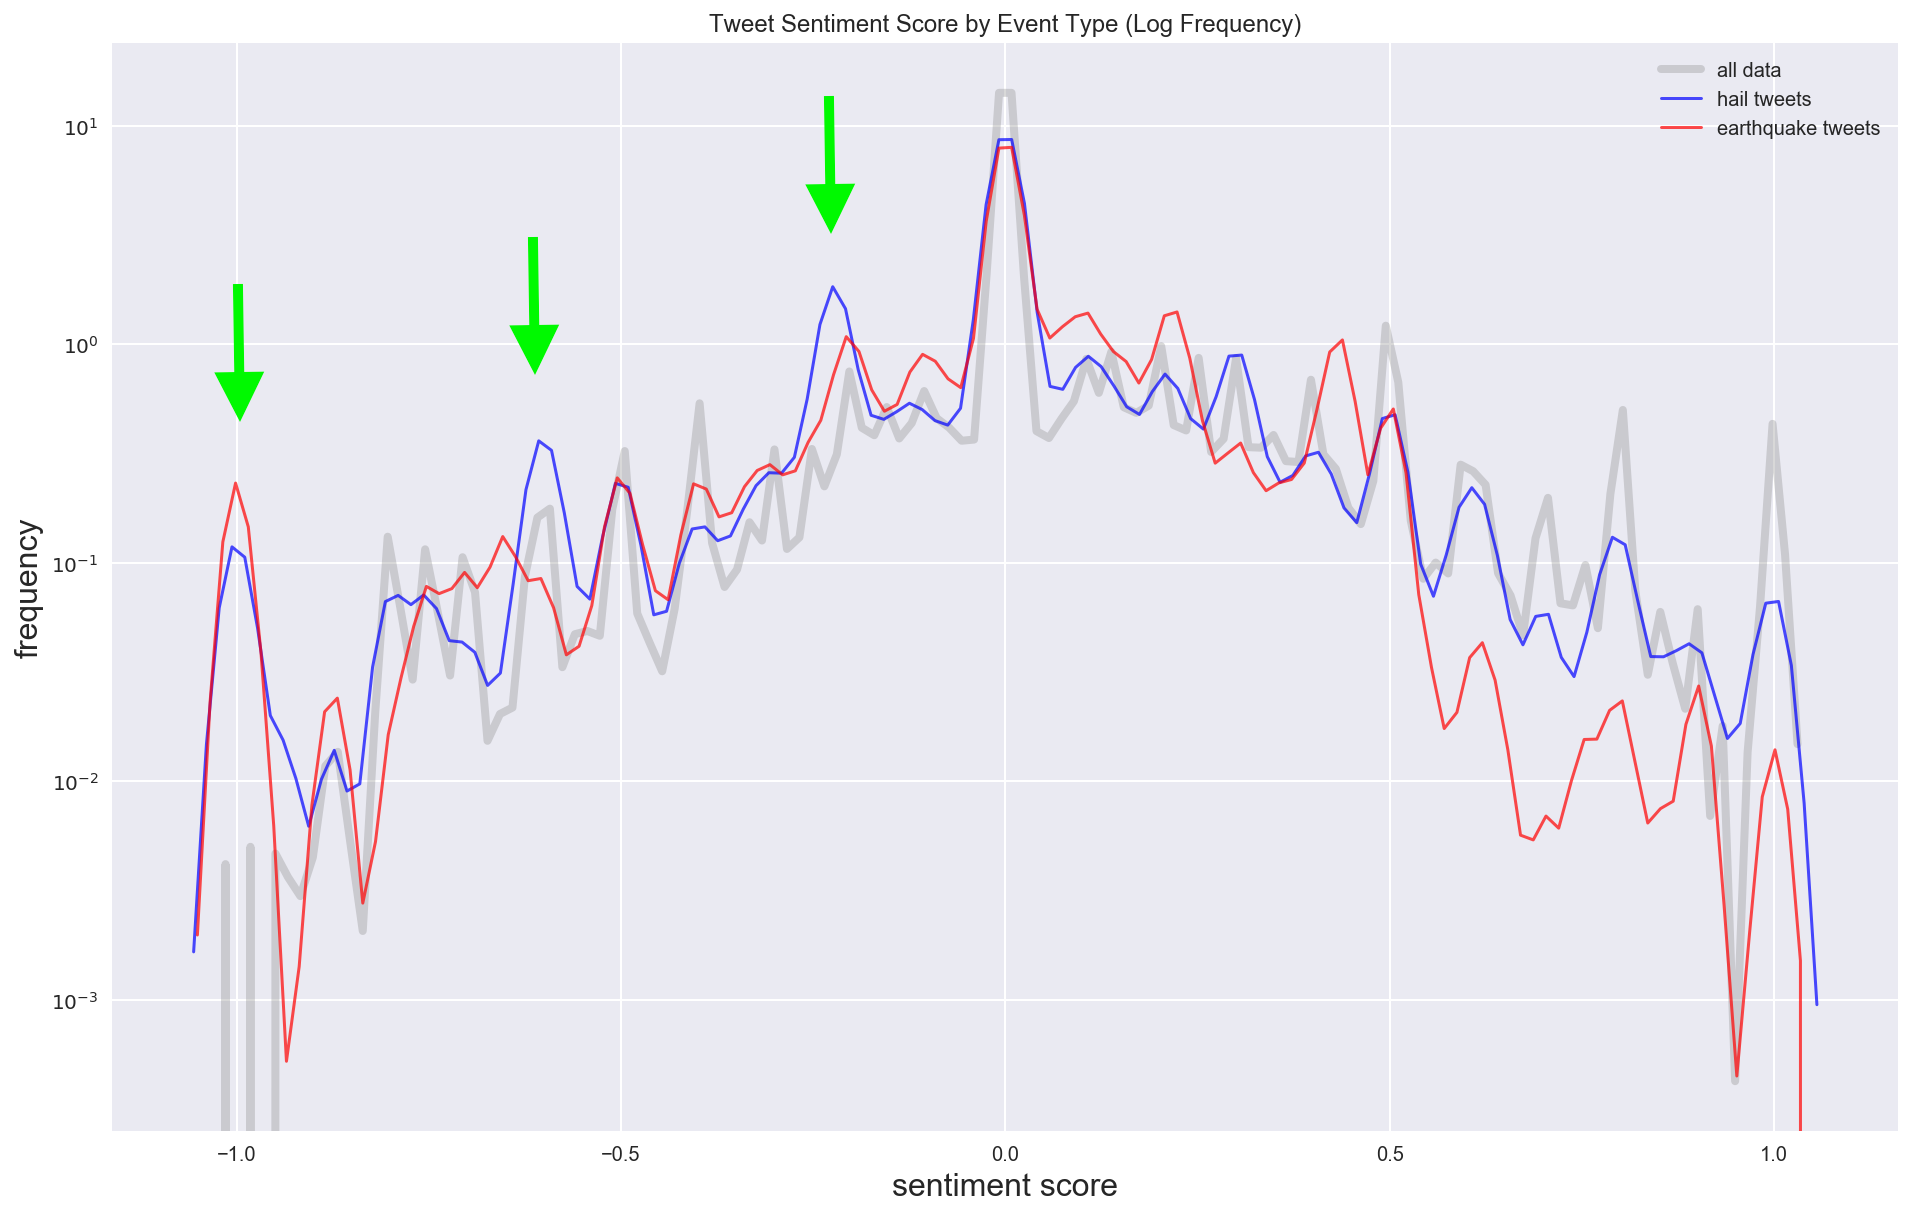

In [12]:
# Figure 7: Sentiment Analysis - All, hail and earthquake tweets
Image(filename='./images/sentiment.png',width=900)

The sentiment analysis results suggest that for the most negative scores, the relative frequency of earthquake and (lesser so) hail tweets are greater than the 'all-tweets' distribution. The inverse is seen at positive sentiment scores.

Three major peaks are observed for negative scores at -0.25, -0.6 and -1.0 where either the hail or earthquake tweets exceed the frequency for all-tweet negative sentiment and in general, there are very few points where the negative sentiment of all tweets exceeds either catastrophe. This indicates the sentiment could be an indicator of catastrophic events and as such, this feature was integrated into the modelling.

Interestingly there appear to be much fewer positive tweets for the earthquake event than the hail events, particularly at very postivie polarities. This implies the event was likely to have very little positive sentiment associated with it, highlighting how destructive it was.

                                                        ***

The statistical analysis and natural language processing have significantly improved our understanding of the data. Some clear relationships between words have been observed and we now understand other events that occurred over the same time periods.


---

### 5. Hail Modelling: Algorithm Development and Evaluation

The primary purpose of the modelling analysis was to develop an algorithm that can effectively classify tweets as being part of a hail event. We know from the NLP analysis that if  word 'hail' is included in the tweet, then there is a very high chance it will indicate a hailing event. However.. what we really want to know is whether the rest of the tweet can effectviely classify this tweet if this term is removed. This will help us classify twitter data even if the specific term does not exist.

In order to create a dataset for modelling, the vectorised data was firstly read-in following NLP processing. A hail class was created to use as our target variable in the modelling. The original hail variable and common location terms were then removed to finalise our predictor (X) dataset. 

Location terms are strong predictors of each hail event (as they were in different place!) so high-count location terms were removed as we want to predict hail without relying on the geography. ***We want to know what people are saying about the hail, how they describe it, rather than were it is.***

To normalise the vectorised word data the term frequency–inverse document frequency (Tfidf) was be calculated. This is a numerical statistic that intends to reflect how important a word is to a document in a collection or corpus. It is a common transformation used in Naive Bayes classification algorithm development and for consistency, is applied for each classification algorithm.

_"The term frequency is typically defined as the number of times a given term t (i.e., word or token) appears in a document d (this approach is sometimes also called raw frequency). In practice, the term frequency is often normalized by dividing the raw term frequency by the document length." Sebastian Raschka, 2014_

### A. Principle Component Analysis

A Principle Component Analysis was performed to investigate whether a smaller number of uncorrelated variables represent a large amount of variance in the dataset and if multicolinearity can be reduced by lowering the number of variables. 

All word predictors (995 in total once location and hail references were removed) were assessed in the principle component analysis to review the dimensionality.

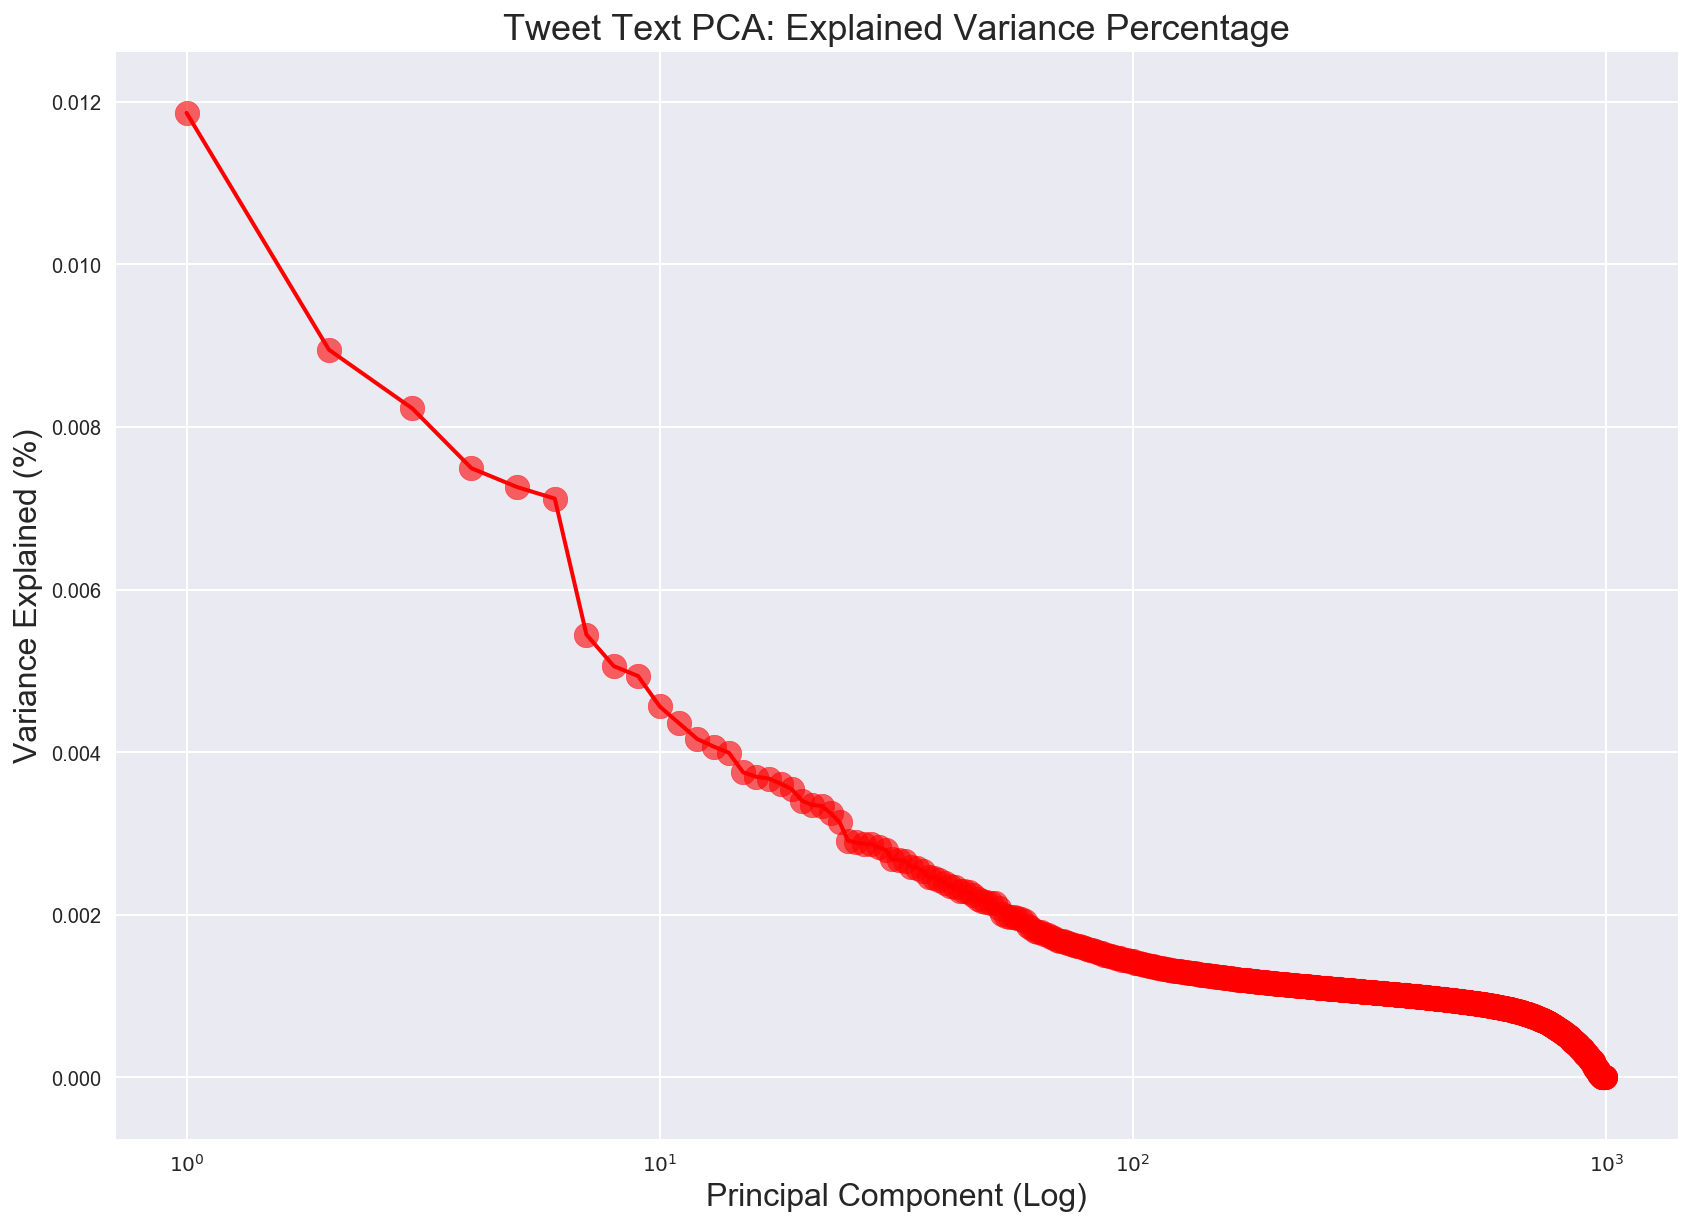

In [13]:
# Figure 9: PCA Explained Variance
Image(filename='./images/pca_components.png',width=900)

The main conclusions of the PCA were:
- The maximum variance explained for any component is 1.2%, which is generally very low but considering the number of variables, it is fairly significant.
- The individual explained variance graph suggests every component explains _some_ of the variance (i.e.: the minimum PC > 0).
- The cumulative variation suggests that if we only wanted to retain 90% of the variance, ~800 components would still need to be retained in the modelling.
- When investigating the X's that contribute to the top-6 components, no single word (X) contributes significantly to the component's overall variance apart from PC1 and the word 'wolf'.

The above observation provides little evidence to suggest that removing principle components would signficantly reduce dimensionality enough to improve model performance, therefore all predictors were used in the model development.

---

### B. Model Development, Tuning and Evaluation

_** Model Development:**_

The modelling analysis investigated four algorithms commonly used in text classification:
    - Naive Bayes
    - Stochastic Gradient Descent
    - Decision Tree
    - Random Forest (Ensemble)

The model development was performed on train/test sets of **50%** of the full dataset (i.e.: the Brisbane and Sydney hail events combined).

The accuracy scores for each model were in excess of 0.96, which is a very strong result. The highest was the ensemble model, a random forest model, which was **0.9710.**

Accuracy Scores:
    - Naive Baybe: 0.9675
    - Stochastic Gradient Descent: 0.9693
    - Decision Tree: 0.9684
    - Random Forest: 0.9710
    
The confusion matricies of each classificaton provide greater insight to the suitability of each model. The random forest classification is the best of the four at predicting the true positives - it has the highest recall and f1 scores. The only area it falls down is the highest false positive rate of the four algorithms, however these are all very low (<0.002) so it is a less significant metric.

F1 Scores for 1-(Hail)-Class:
    - Naive Baybe: 0.32
    - Stochastic Gradient Descent: 0.38
    - Decision Tree: 0.38
    - Random Forest: 0.48

The f1 scores for the 1-class (hail) are significiant because all models have 0-class f1 scores of 0.98. All other classification metrics are too similar to extract meaningful conclusions, therefore the 1-class f1 score and the accuracy suggest that the random forest classifier is the most appropriate algorithm for hail modelling.

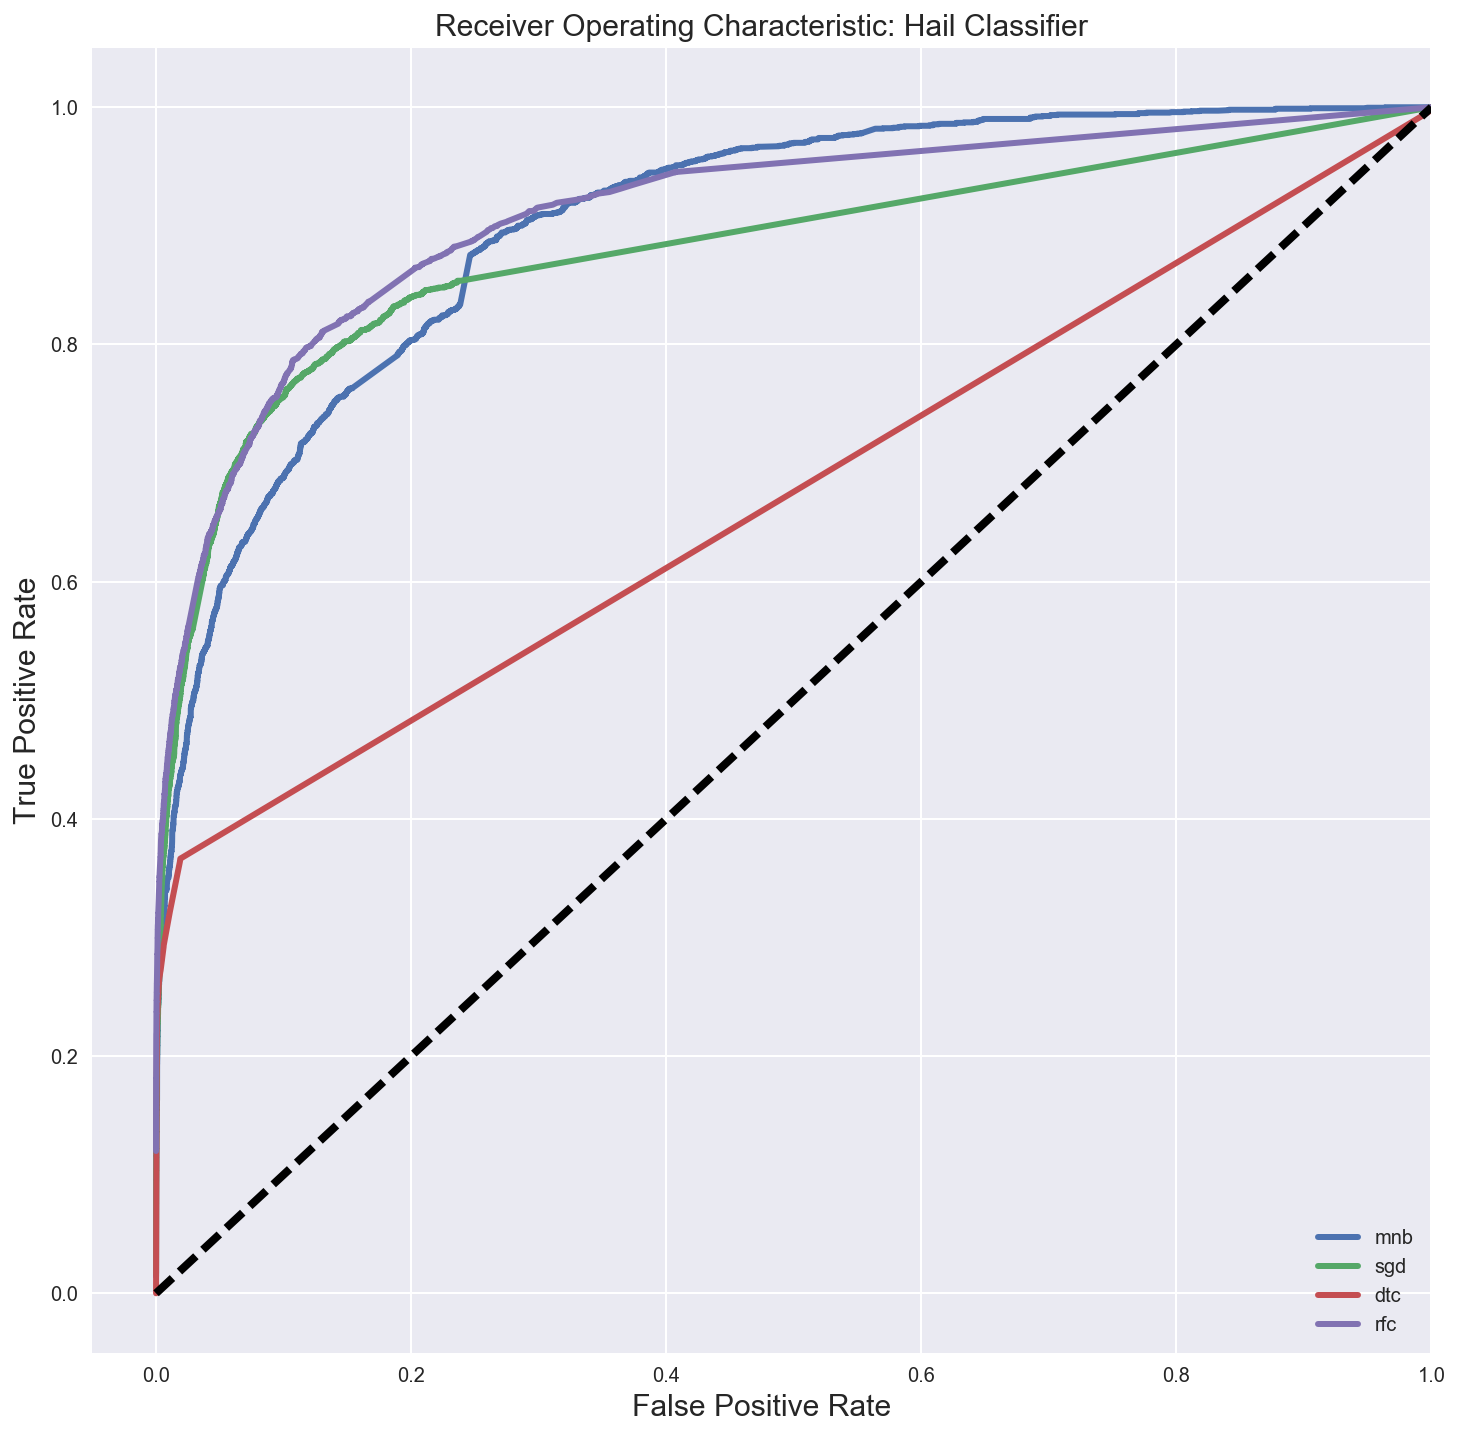

In [14]:
# Figure 10: ROC curve for classification model investigation
Image(filename='./images/roc_hail_models.png',width=800)

The ROC plot confirms the results of the classifications well; the most optimal model, with the largest ROC curve area, is the Random Forest algorithm, followed by stochastic gradient descent and naive bayes.

**Note:** _The Support Vector Machines algorithm was trialled but results were poor, so were removed from the notebook. This was a suprising result as research indicated it is commonly used in text classification. Investigating this algorithm further is a potential extension of this analysis._

---

_** Model Tuning **_

To tune the model I performed a cross-validation gridsearch to determine the optimal hyperparameters using the full dataset. This was done to ensure the random forest classifier is effectively tuned.

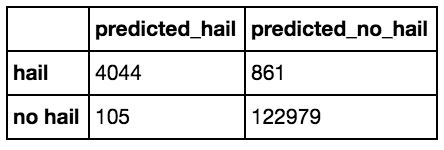

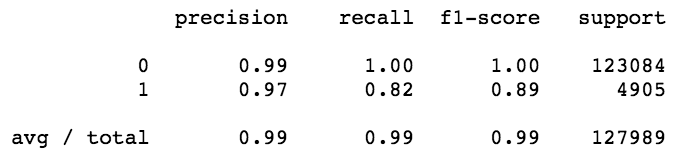

In [15]:
# Figure 11. Tuned model performance
a = Image(filename='./images/gs_matrix.png',width=300)
b = Image(filename='./images/gs_class_report.png',width=500)
display(a,b)

The results of the gridsearch are very positive. The optimal random forest classifier predicts the hail class very well, with an overall accuracy score of 0.9680 and f1 score of 0.99. 

This result would generally be expected as it tests the same dataset as used for training, however it provides more confidence in our algorithm choice and its ability to predict hail.

---

_**Model Evaluation**_

I will now evaluate the optimised random forest model by training and testing on the two hail events separately. This will review the effectiveness of the hyperparameters and investigate which words are most important to classify hail in each event.

When the Brisbane data (the severe event) is used to train the algorithm and Sydney data tests, the model performs poorly with a very low true positive rate. When the opposite is evaluated (Sydney train, Brisbane test) the model performs slighty better (increased recall/f1), although it is still poor considering the high accuracy score. **This implies that different predictors drive hail classification in each event.**

The features driving the Brisbane event-fitted algorithm appear to be extreme language, such as **chaos, massive, super and worst**, whereas the Sydney event is less strong, with predominantly meterological terms. This indicates the impact on humans (i.e.: damage to property, injuries) was more severe in the Brisbane event which, as we know, had an insurance loss 3.5 times the size of Sydney.

                                                           ***

Overall the random forest algorithm, once tuned, performs very well at predicting hail classes from tweet text. The true positive percentage (80%) is much higher than the train/testing method used to originally investigate the other classification methods. Whilst this is expected due to training the data on the full dataset, such a high true postive rate is a very positive outcome and gives confidence in the selected hyperparameters. 
***It is clear that the larger the training dataset size, the more effective the model is at predicting hail.***

It is also clear that the text tweeted during Brisbane and Sydney hail events had different language and preliminary investigation certainly shows that more extreme language was used during the more severe event. This will now be investigated further by reframing the classification exercise.

---

### 6. Hail Severity Modelling

Now we have confidence that words in tweets can predict hail events to a moderate degree of accuracy, we can investigate the second goal:

       - Can twitter data identify severe catastrophic hail events?

The key word here is _severity_ and in the context of this investigation, this means hail events that produce a greater financial loss and damage. Training and testing our algorithm using the two events in our dataset has already indicated that different words are more important to classify each event.

This analysis was extended in a new classification model with a different target. A subset of the dataset was created for **hail-only** tweets (i.e.: ['hail'] > 0), which created a dataframe of **4,786** rows. The optimal random forest model, as determined during the hail modelling, was used in this analysis.

***Results:***

- The overall accuracy score of the model is 0.81. This is a reasonable result considering we used no feature selection, PCA or fitted hyperparamters (note: these have been identified as areas to investigate further as extensions of this project).
- The classification report indicates an overall f1 score of 0.81, which implies there is significant variability between the predictors that classify each event.

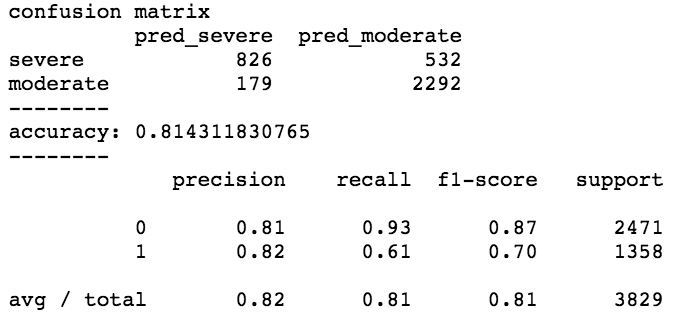

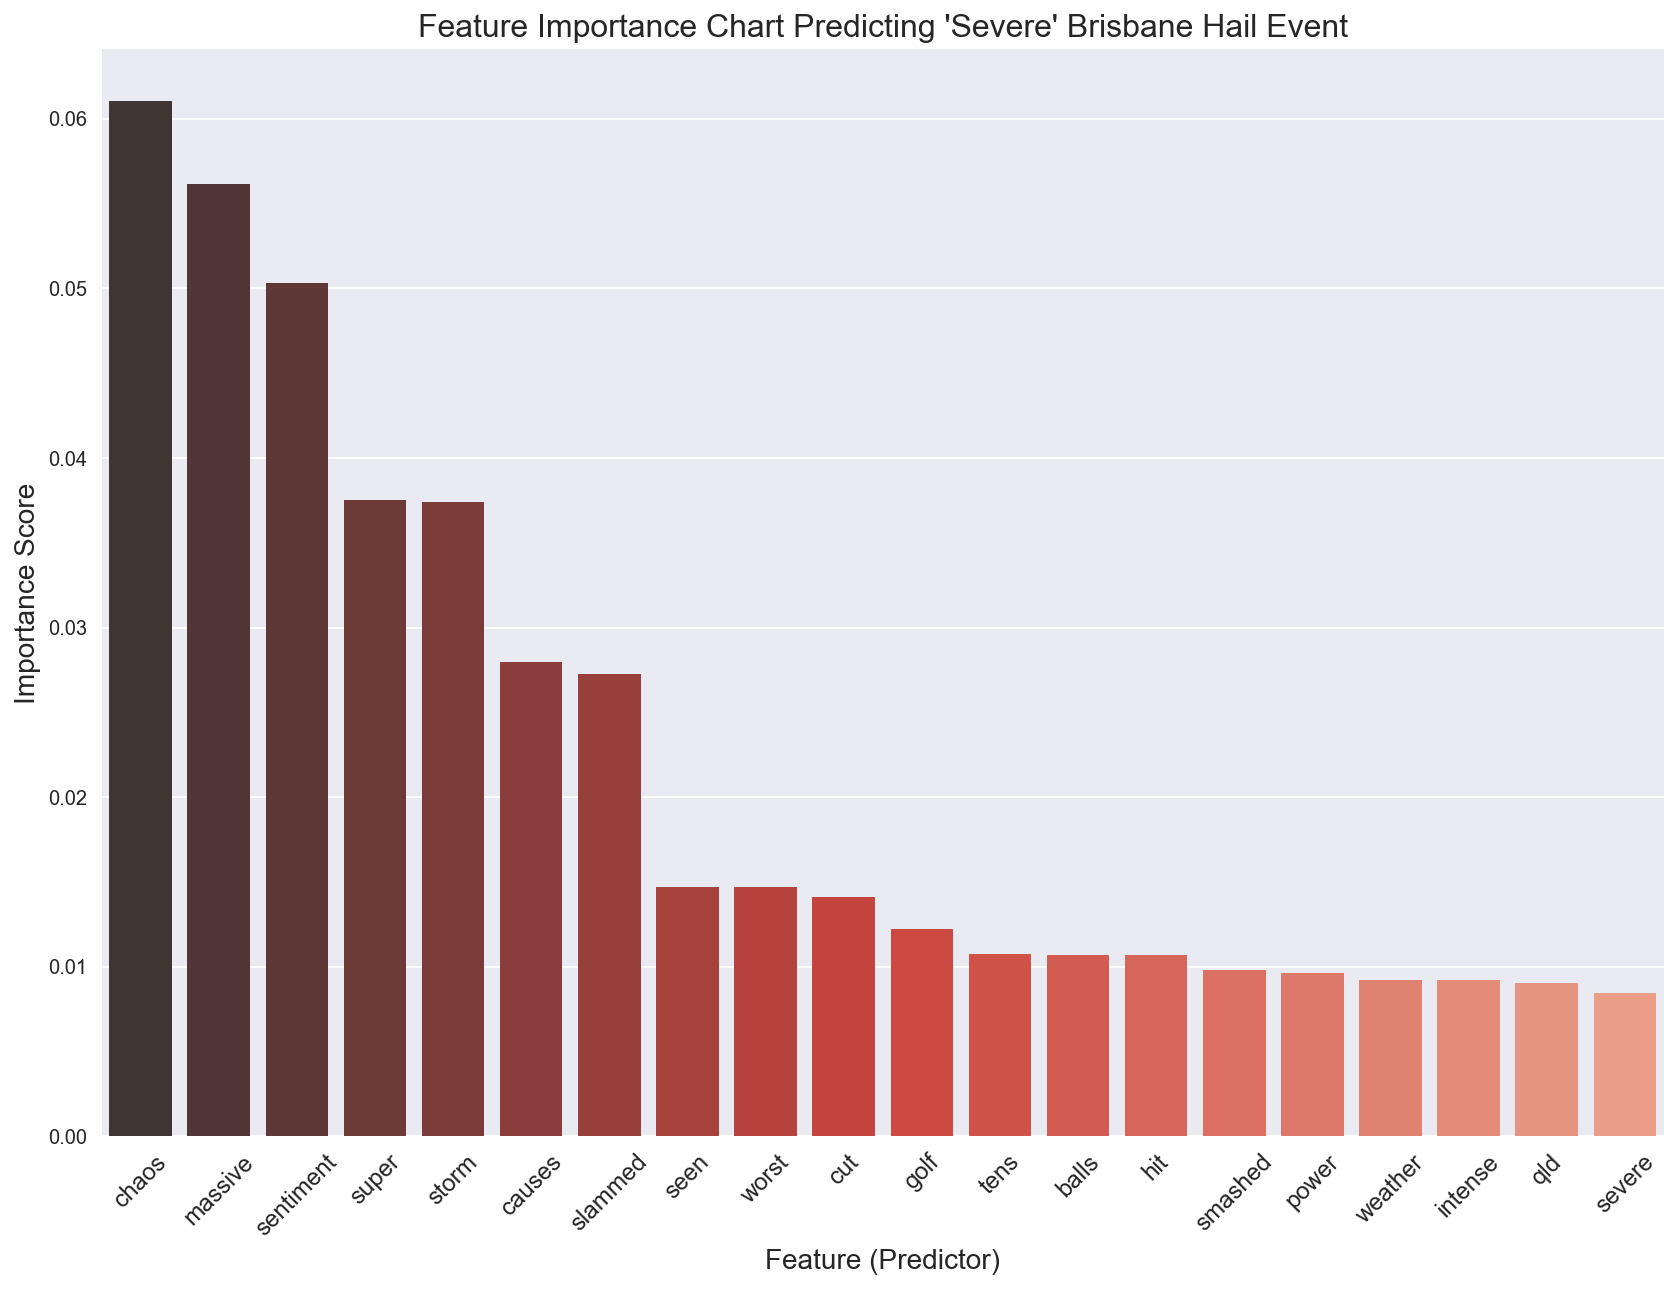

In [16]:
# Figure 12. Severity Classification Results: Confusion Matrix, Classification metric and feature importance graph. 
c = Image(filename='./images/severity_report.png',width=500)
d = Image(filename='./images/features_severity.png',width=800)
display(c,d)

- The features that are most important in the classification are certainly more indicative of severity. Similar to the event Brisbane-train/Sydney-test analysis, words like chaos, massive, super feature with high importance. We also observe words that indicate damage, such as golf, ball, causes, power, and of course _severe_.

                                                    ***
                                                    
It is clear that language in tweets relating to hail events can indicate **severity** and our model can predict moderately well whether a tweet refers to a more severe event. It must be noted that we only have data for two known hail events and if we were to integrate more events, the severity predictability would increase in accuracy and confidence.

---

### 7. Earthquake Classification Modelling

The discovery of a second catastrophe type - an earthquake event - not only confirms our search criteria is robust enough to capture natural disasters other than hail, it provides us with an opportunity to investigate an alternative classification.

The serendipitous identification of another type of catastrophe in this study will now be integrated with our optimal hail algorithm to investigate whether it can also effectively classify tweets of a second type of catastrophe.

A new class target was created using 'hail' and 'earthquake' word frequencies and again, location words for Brisbane, Sydney and Nepal were removed as predictors to remove their strong predictability. The total dataset was used in this analysis (127,989 data records) and the model is trained/tested with a **80/20** split.

_Catastrophe class creation:_
        - hail_tweet_text['hail'] >= 1 :  **Class 1**
        - hail_tweet_text['earthquake'] >= 1 :  **Class 2**

***Results:***

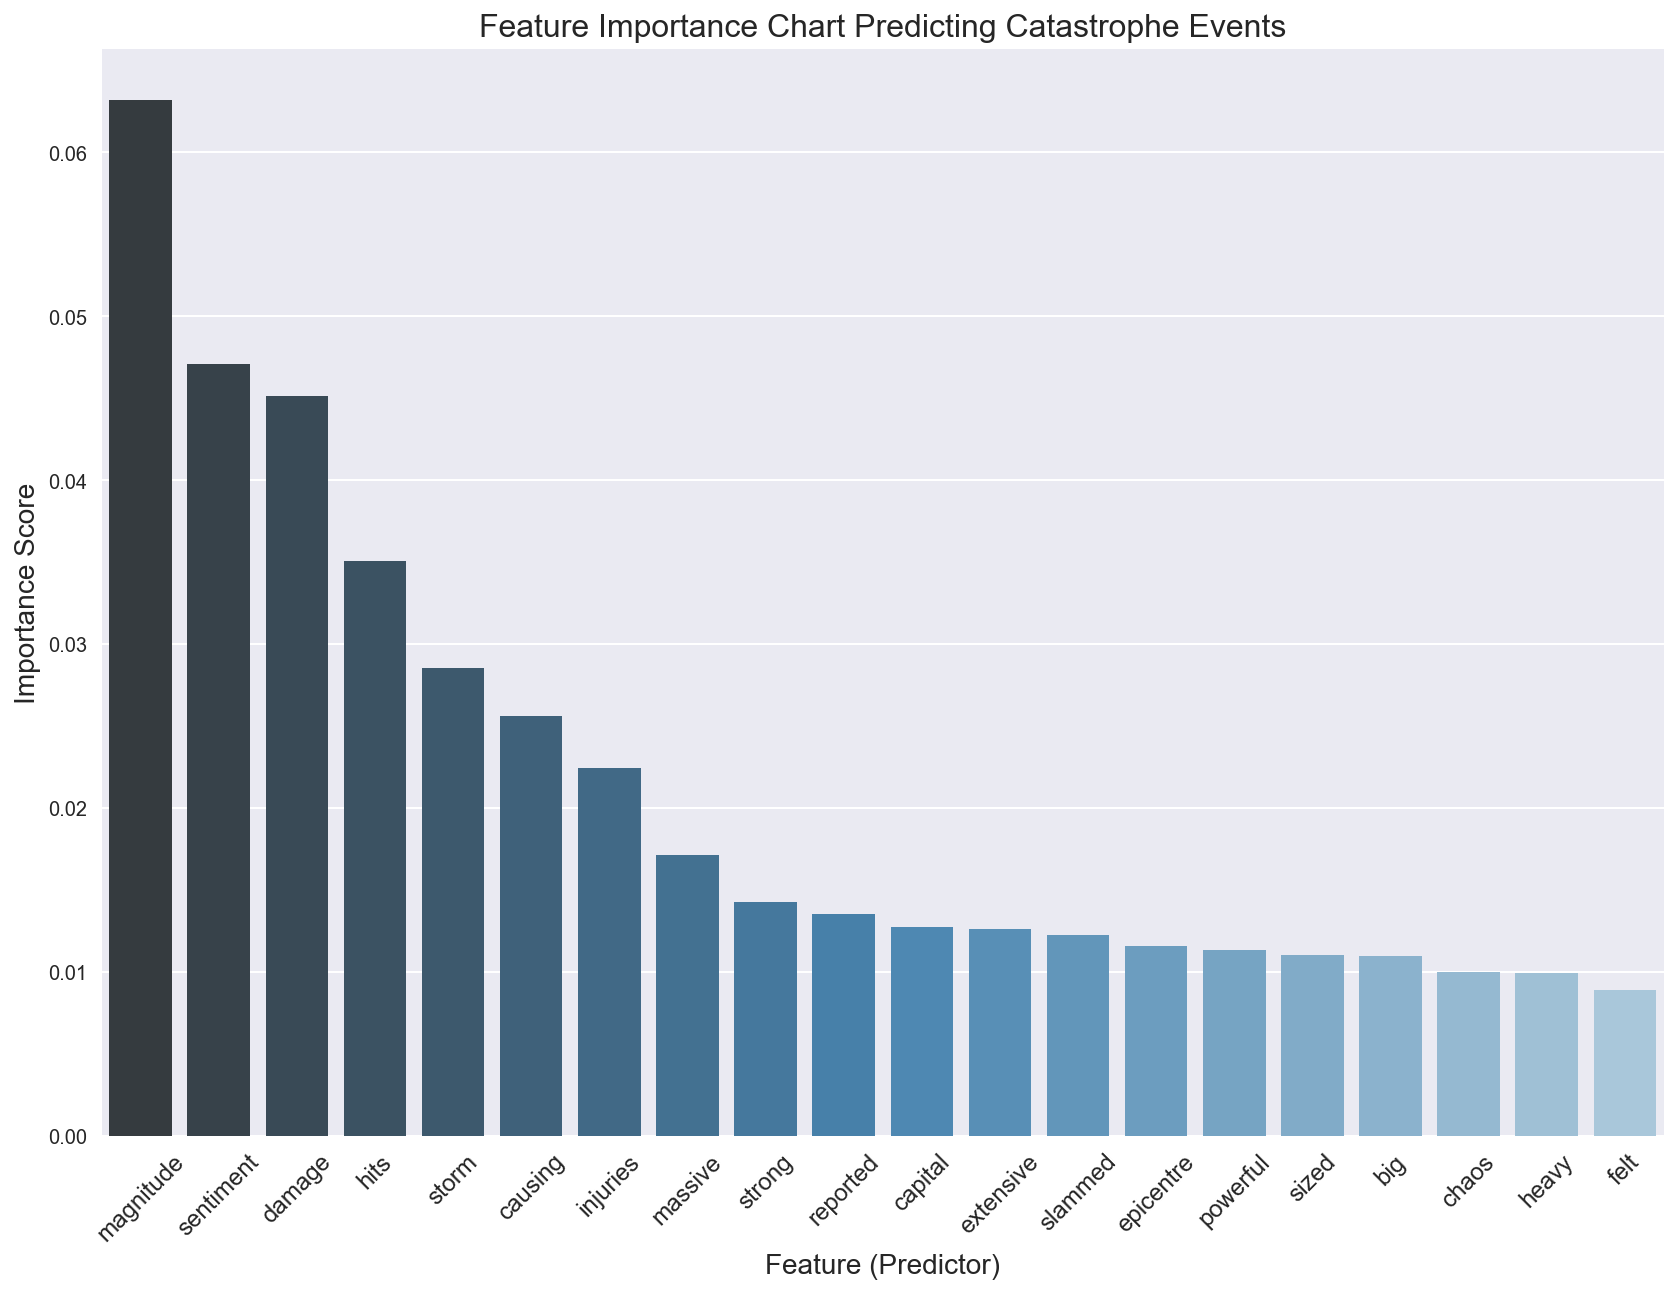

In [17]:
# Figure 13. Catastrophe Classification Feature Importance Chart 
Image(filename='./images/features_eq.png',width=800)

The accuracy score of the three-class catastrophe classification is **0.9577**; slightly less than the hail model classification but still a high value.

When trained with 80% of the full dataset, the algorithm's ability to predict each class in the test data is different. As depicted by the ROC curve, the number of true positives (and the precision and recall) for the earthquake class is much higher than hail, and even the 0-class.

When introducing the earthquake class, the feature importance top-20 ranking includes new terms such as **magnitude, strong, felt, powerful**. These are typical terms associated with describing significant earthquakes. 'Damage' ranking at number two and the introduction of 'injuries' also implies another severe event being introduced into the classification

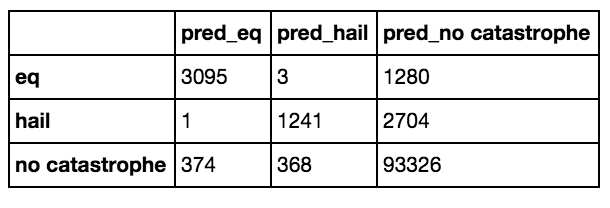

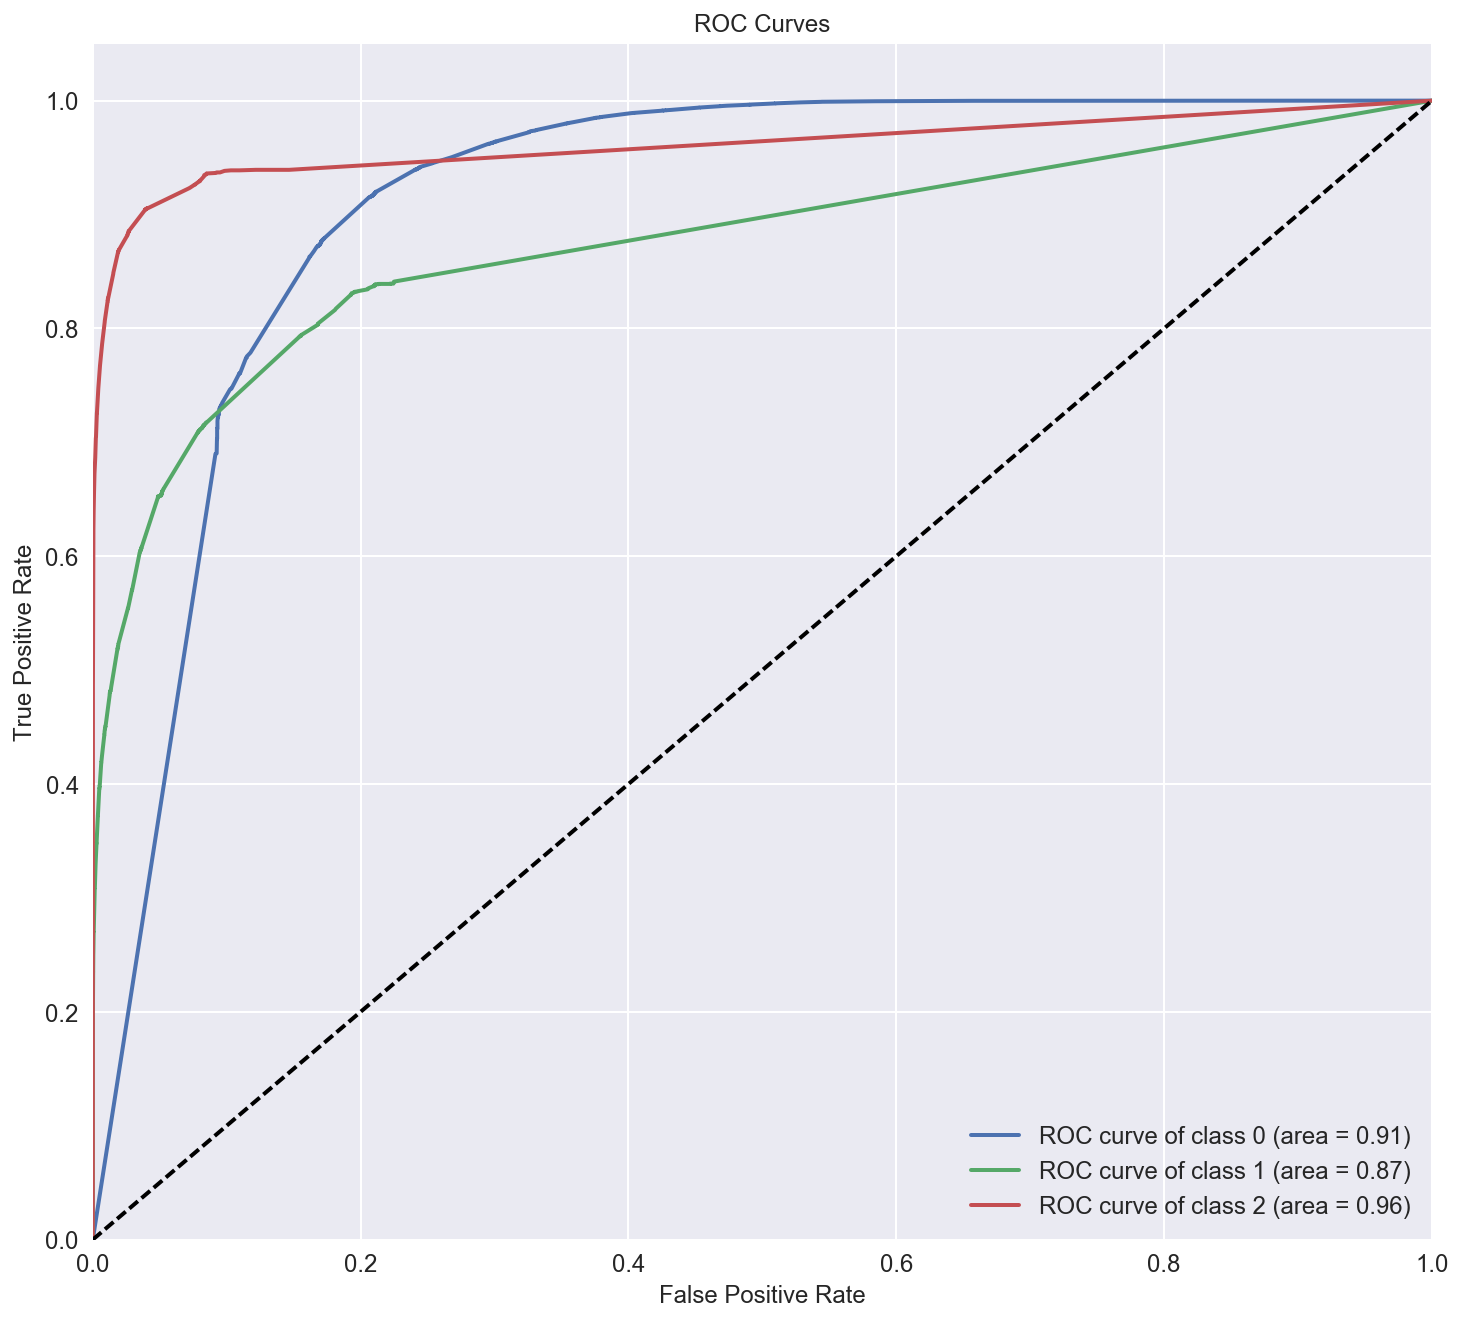

In [18]:
# Figure 14. ROC Curve for each catastrophe clas
e = Image(filename='./images/eq_matrix.png',width=400)
f = Image(filename='./images/roc_eq.png',width=800)
display(e,f)

From the confusion matrix we conclude that the model is good at classifying the _type of catastrophe_, when it is indeed that catastrophe (i.e.: the model classifies low values of predicted-earthquakes when it is true hail, and vise versa), but in general, when introducing the earthquake class, hail prediction performs less well than the hail-only modelling.

                                                        ***

The combined earthquake+hail classification is a useful exercise to investigate the effect of adding in a second disaster type however the reduced f1 score of the hail classification indicates that if multiple catastrophes wish to be monitored and predicted in a deployed model, **separate algorithms that are optimised and trained specific to each catastrophe type may be more appropriate.**

---

### 8. Conclusions: Interpretation of Findings and Goal Review

The purpose of this project was to conduct an investigation into whether twitter data can predict a natural catasatrophe. The specific goals were framed as two key questions:

    - Can twitter data detect hail events from the language people use in tweets?
    - Can twitter data identify severe catastrophic hail events?

Originally the **tweet volume, location and language** were hypothesised to be the three potential drivers of predicting catastrophic loss from twitter data. It became apparent early on in the investigation that volume and location were not the most important factors in determining this.
- **Tweet Volume:** the volume, or number of tweets, with 'hail' references for the Sydney event were nearly double that of the Brisbane event. The Brisbane event hwoever was 3.5 times the insured loss. Too many factors influence how people tweet. This includes the time of day and how many twitter users there are in a specific area (i.e.: the Brisbane population is half the size of Sydney). Whilst the volume could be adjusted to account for these factors, there would still be too much uncertainty to use volume as a robust predictor for severe events.
- **Tweet Location:** the user location information provided with the tweet records was very low. Where available (<0.5% of the total dataset) locations were externally geocoded to get a flavour for the geographic distribution of the tweets but overall it was not extensive enough to use in modelling. The locations provided in the actual tweet text however were found to be good predictors of each event - e.g.: Brisbane is an obvious predictor for the Brisbane hail event - but these were removed in the modelling so the other words could be investigated without these strong predictors influence the classification. The locations found were also coarse resolution, so little conclusion could be gathered on how extensive the event's geographic footprint might be.

The third factor - _language_ - proved to be the most successful at predicting hail events and will be discussed with respect to each goal...

##### Can twitter data detect hail events from the language people use in tweets?

Hail events were successfully identified at multiple stages in the analysis:
- NLP successfully identifes words that relate to the hail events in question and significant activity of the terms 'hail' and 'hailstorm' were registered during the hours each event was known to occur.
- The topic modelling identified strong clusters of words that relate to the hail events, particularly when subsets of  data were analysed specific to the time periods of each storm.
- Sentiment analysis recorded negative polarity of hails tweets exceeding the frequency of all-tweets. This aligns with the common prevalence of negative, extreme language during natural disasters.
- The hail modelling also produced a number of very promising results. The predictors were able to produce a random forest classification algorithm that accurately predicted 80% true positives of known positives when trained on the full dataset. The presicion and recall of this model increases with training size and with further samples of more hail events, it will likely improve further.

##### Can twitter data identify severe catastrophic hail events?

Knowing the impact of the Brisbane and Sydney hail events allows us to draw some conclusions on how well language recognises more damaging catastrophes. There were a number of results that correctly indicate the more severe Brisbane hail storm:
- NLP: Recognition of terms relating to severity within the NLP processes; specifically the bag-of-words analysis and topic modelling of each event.
- Training and testing the optimal hail model algorithm on each event: The poor ability of each event to predict hail classes in the other suggests the predictors that drive hail classification differ for each event.
- The event classification analysis produced strong results at predicting each event. This reinforces the severity difference between events. The predictors that drive this classifciation model are extreme words such as _chaos, massive, super and slammed_.

##### Extension... Can twitter data identify other types of catastrophic events?

Finally to the analysis extension; an introduction of a second catastrophe type. The discovery of the Nepal Earthquake was a positive confirmation of our search criteria, NLP processing and it allowed us to broaden the scope of the project into a third modelling investigation. The combination of earthquake with the hail class provided a promising result again, particularly for the earthquake class which had the highest f1 score of all three classes. This suggests that tweets can effectively recognise earthquake events, likely due to such specific terminology commonly used for that type of disaster such as _magnitude and hits_.

                                                        ***

Overall the results appear to answer our problem statement questions with positive results and the project certainly delivers on our ultimate goal; to understand whether social data can indentify **severe, natural catastrophes**. For the two hails events selected in particular, tweets seem to be moderately successful at predicting hail and how severe it is.

Despite the successes there are a number of improvements and extensions that would enhance this project, which will be discussed within stakeholder recommendations.

---
### 9. Stakeholder Recommendation and Next Steps

The following recommendations will improve this analysis prior to model deployment (discussed as an extension to this section)...

1. Introduce more hail events to strengthen our classification model. More mid-tier events (i.e.: between the Sydney and Brisbane magnitude of loss) and more transitional events (<100M AUD) would allow us to make more confident conclusions about the terms driving the severity classification.
- Create a method that infers location from text and investigate clustering with known tweet location data. This would significantly improve the volume of coordinates in the data and our knowledge of tweet locations.
- Investigate sentiment analysis for the specific events - does polarity differ for more/less severe events?
- Further algorithm analysis should be performed. This includes more intensive training/testing of data beyond the 50/50 split for the current algorithms and looking at others such as SVM.
- Investigate other types of natural catastrophe. Earthquake was already identified but bushfires, floods and cyclones are also very common in Australia.
- Also... investigating alternative data sources could enhance this type of investigation. Text classification of facebook posts and image recognition of instagram posts are other potential social resources.

---

### 10. Model Deployment: Retraining and Production

Another stakeholder recommendation is to consider deploying the model in a production environment.

The following diagram outlines a potential framework for the random forest classification algorithm to be used as a real-time natural catastrophe monitoring model.

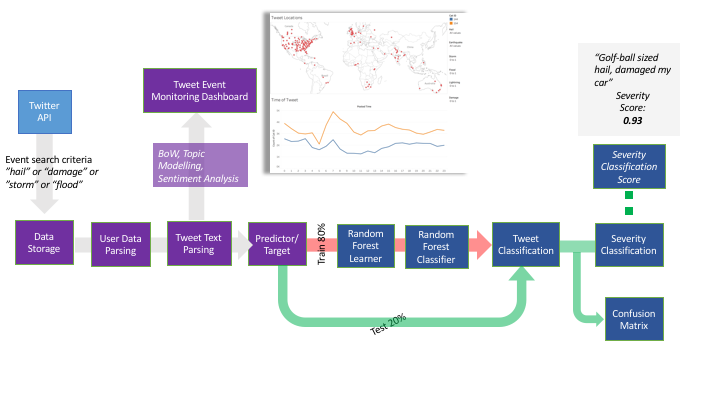

In [19]:
# Figure 15: Suggested Model Deployment Framework including sample Tableau Dashboard
Image(filename='./images/model_deployment.png',width=1000)

Deployment Process:

1. Capturing twitter data live using the Twitter API in real time during a natural catastrophe, storing in a cloud or server environment.
- Use the data parsing techniques developed in this project (for the user and tweet text processes) to produce a cleaned dataset for modelling.
- Deploy NLP processes to analyse the tweet text and display results in live-reporting dashboard (e.g.: Tableau)
- Once the target/predictors are created, train the existing model on the new data and review the performance in a feedback loop. False positives (i.e: results that suggest that they are hail tweet that do not have the word 'hail' within them), perform a confidence score to assess the likelihood of it being a hail tweet. This scoring method is developed using the latest algorithm's feature importance scoring.
- Following the tweet classification, perform a tweet severity scoring. This process will be similar to the hail class scoring but will use the latest feature importance from the event classifiction algorithm developed. The aggregation of the scores for each tweet will be the overall indicator of event severity and over time, we will be able to make loss comparisons with historical events.

---

---